In [1]:
import pandas as pd

# Load the original CSV file
file_path = '/Users/cameronmacquarrie/Downloads/Yahoo-431.l.148152-Matchup (17).csv'
data = pd.read_csv(file_path)

# Group the data by 'Week'
grouped_data = data.groupby('Week')

# Define a dictionary for team ID to name mapping
team_id_to_name = {
    '431.l.148152.t.1': 'Drew',
    '431.l.148152.t.2': 'Cameron',
    '431.l.148152.t.3': 'Micah',
    '431.l.148152.t.4': 'Evan',
    '431.l.148152.t.5': 'Kevin',
    '431.l.148152.t.6': 'Phil',
    '431.l.148152.t.7': 'Eduardo',
    '431.l.148152.t.8': 'Ben',
    '431.l.148152.t.9': 'James',
    '431.l.148152.t.10': 'Nick'
}

# Combine all normalized data into a single DataFrame for each team
team_sheets = {}

for week, group in grouped_data:
    normalized_data = pd.DataFrame()
    
    for _, row in group.iterrows():
        # Team 1 data
        team_1_data = {
            'Week': row['Week'],
            'Team ID': row['Team 1 ID'],
            'Team Name': row['Team 1 Name'],
            'Points': row['Team 1 Points'],
            'R': row['Team 1 R'],
            'HR': row['Team 1 HR'],
            'RBI': row['Team 1 RBI'],
            'SB': row['Team 1 SB'],
            'AVG': row['Team 1 AVG'],
            'W': row['Team 1 W'],
            'SV': row['Team 1 SV'],
            'K': row['Team 1 K'],
            'ERA': row['Team 1 ERA'],
            'WHIP': row['Team 1 WHIP']
        }
        team_1_id = row['Team 1 ID']
        if team_1_id not in team_sheets:
            team_sheets[team_1_id] = pd.DataFrame()
        team_sheets[team_1_id] = pd.concat([team_sheets[team_1_id], pd.DataFrame(team_1_data, index=[0])], ignore_index=True)
        
        # Team 2 data
        team_2_data = {
            'Week': row['Week'],
            'Team ID': row['Team 2 ID'],
            'Team Name': row['Team 2 Name'],
            'Points': row['Team 2 Points'],
            'R': row['Team 2 R'],
            'HR': row['Team 2 HR'],
            'RBI': row['Team 2 RBI'],
            'SB': row['Team 2 SB'],
            'AVG': row['Team 2 AVG'],
            'W': row['Team 2 W'],
            'SV': row['Team 2 SV'],
            'K': row['Team 2 K'],
            'ERA': row['Team 2 ERA'],
            'WHIP': row['Team 2 WHIP']
        }
        team_2_id = row['Team 2 ID']
        if team_2_id not in team_sheets:
            team_sheets[team_2_id] = pd.DataFrame()
        team_sheets[team_2_id] = pd.concat([team_sheets[team_2_id], pd.DataFrame(team_2_data, index=[0])], ignore_index=True)

# Save all teams' data into a single Excel file with each team having its own sheet with shortened names
excel_file_path = '/Users/cameronmacquarrie/Downloads/Yahoo_Matchup_week23.xlsx'
with pd.ExcelWriter(excel_file_path) as writer:
    for team_id, df in team_sheets.items():
        sheet_name = team_id_to_name.get(team_id, team_id.split('.')[-1])
        df.to_excel(writer, sheet_name=sheet_name, index=False)

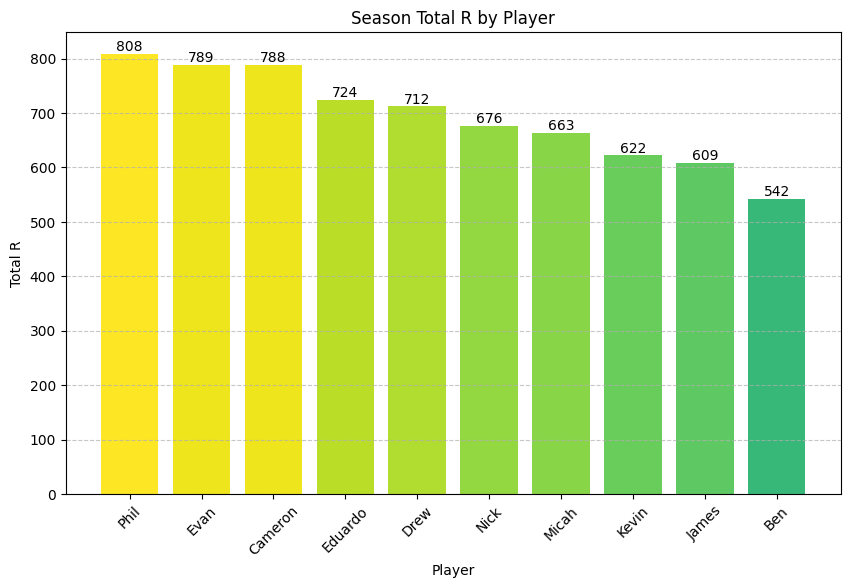

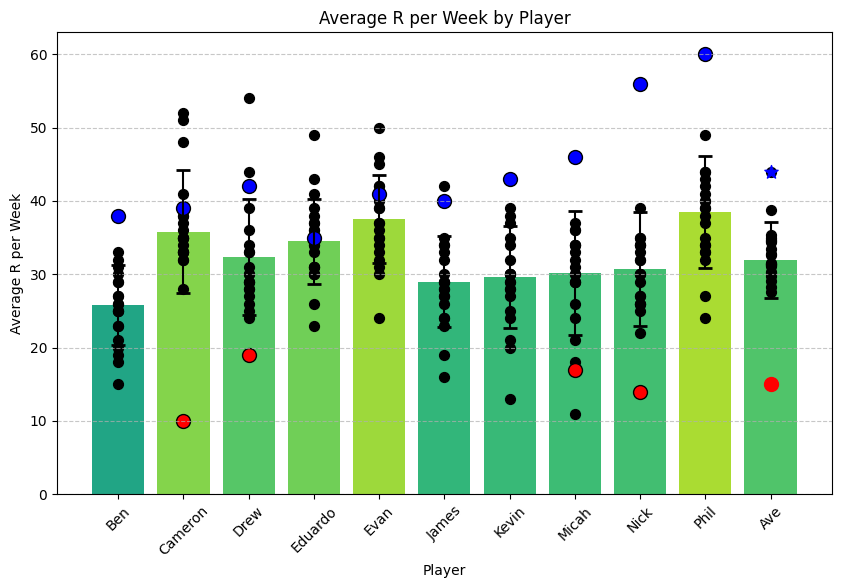

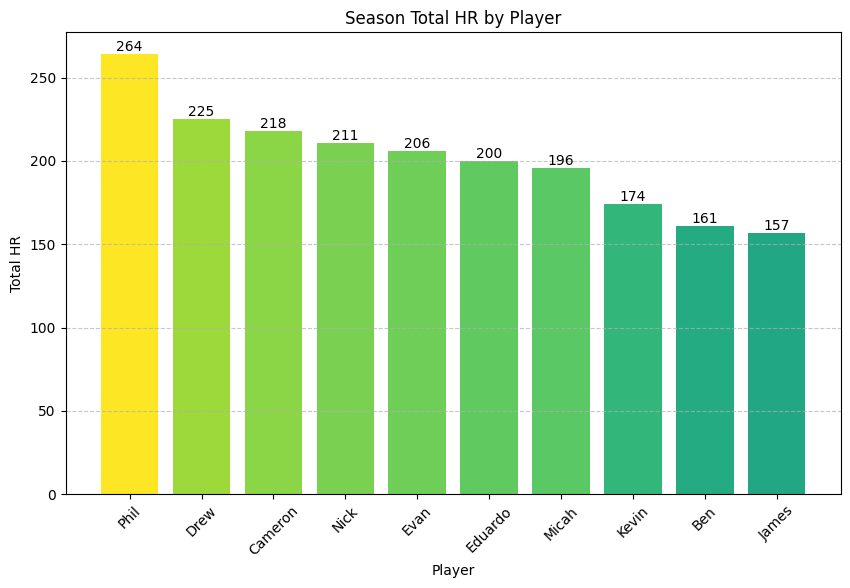

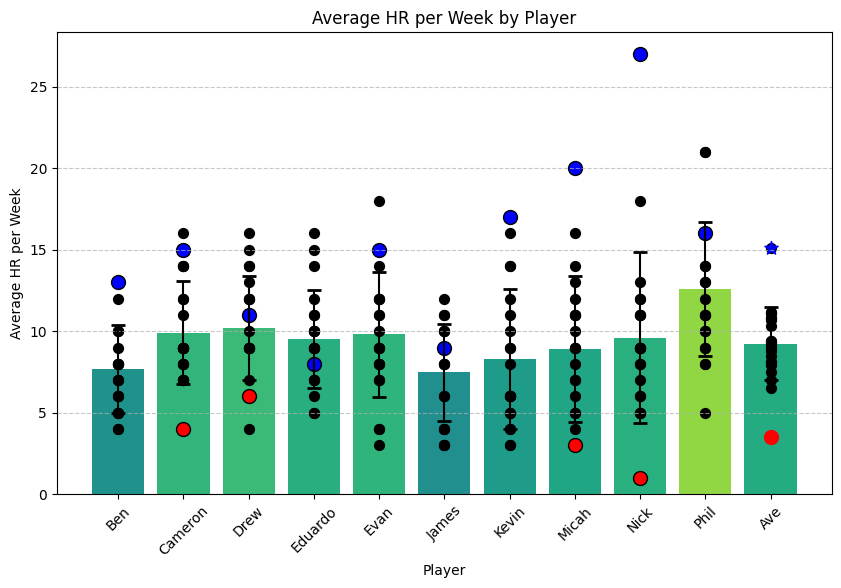

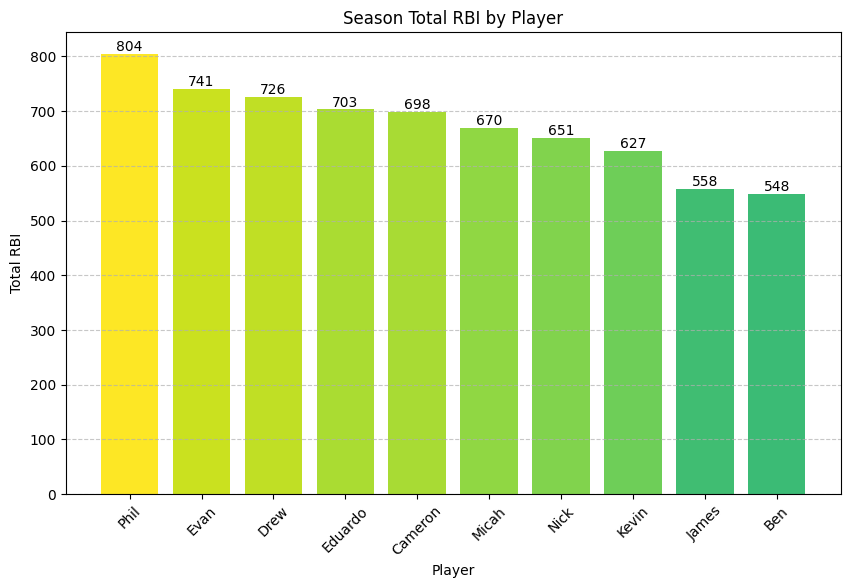

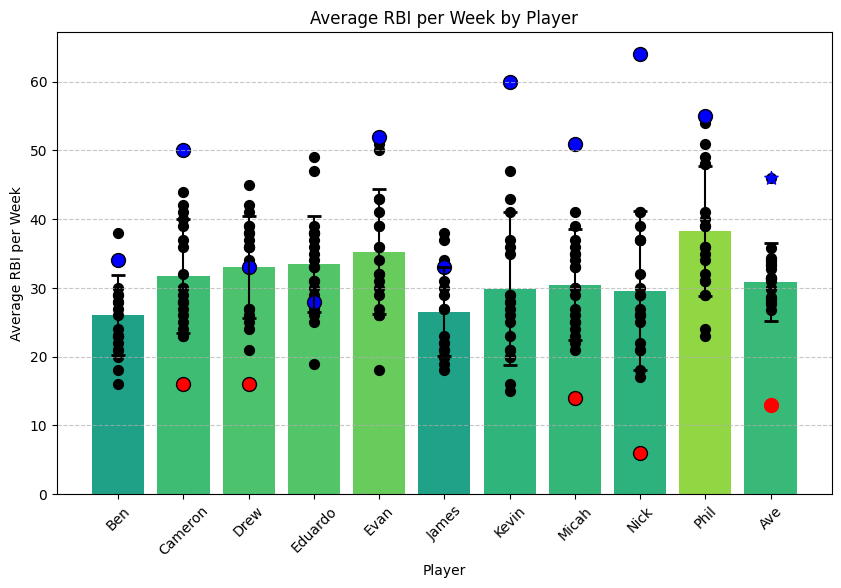

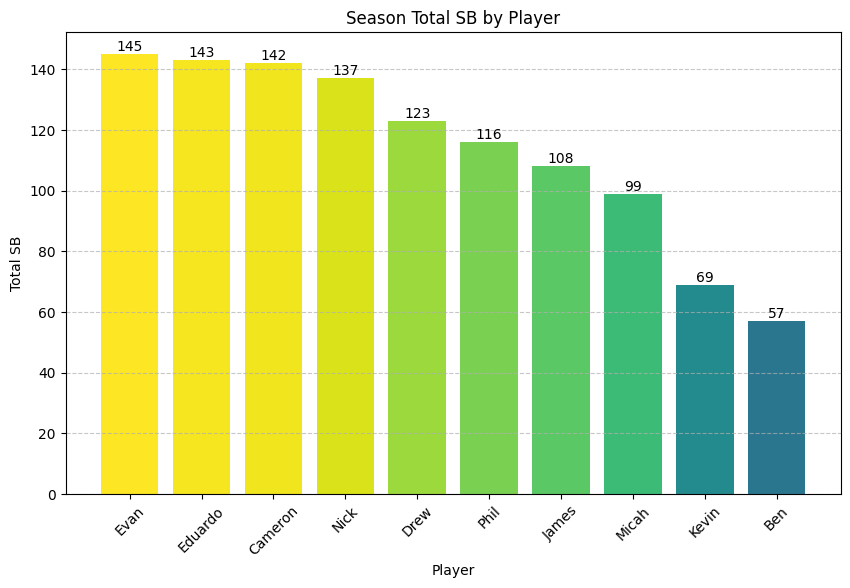

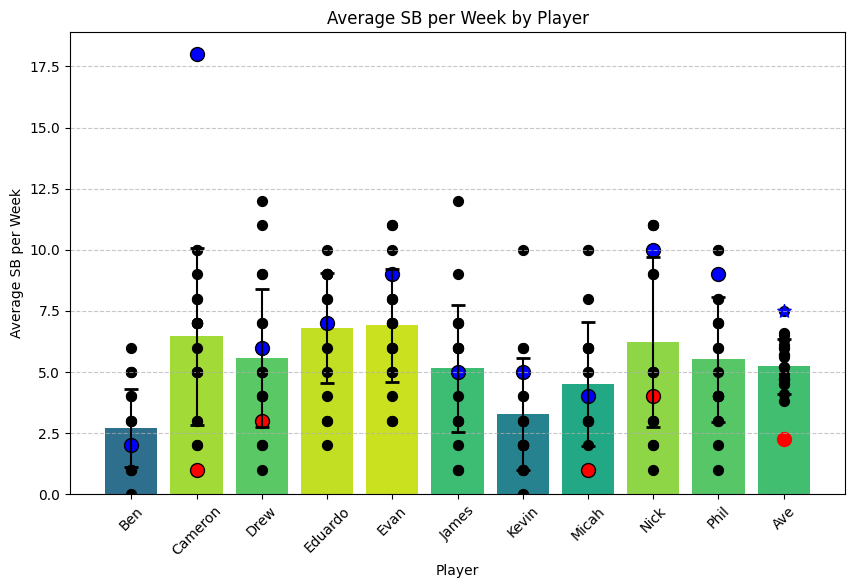

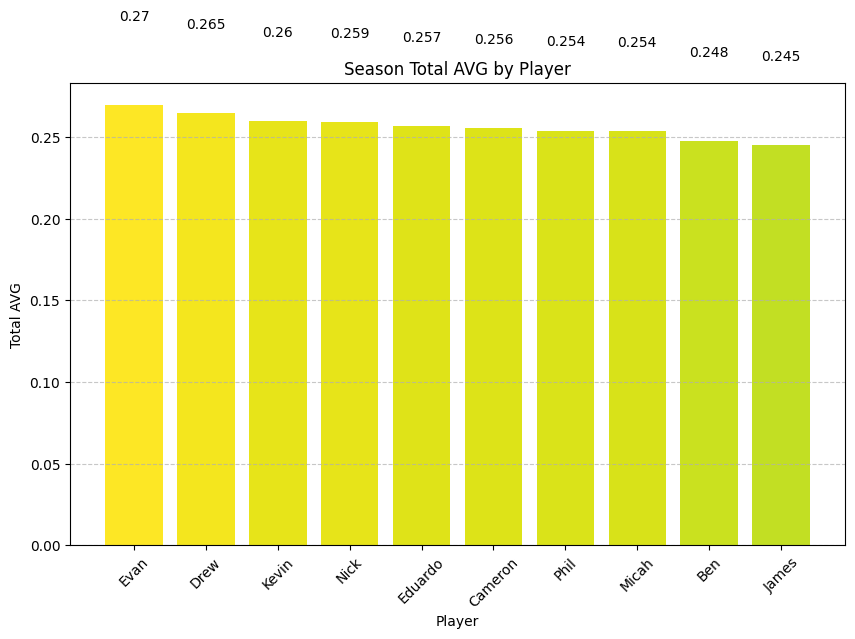

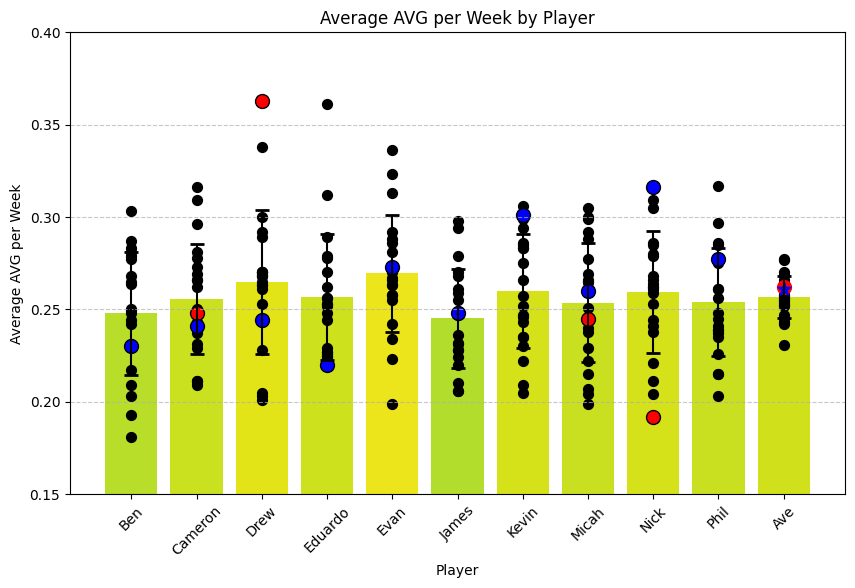

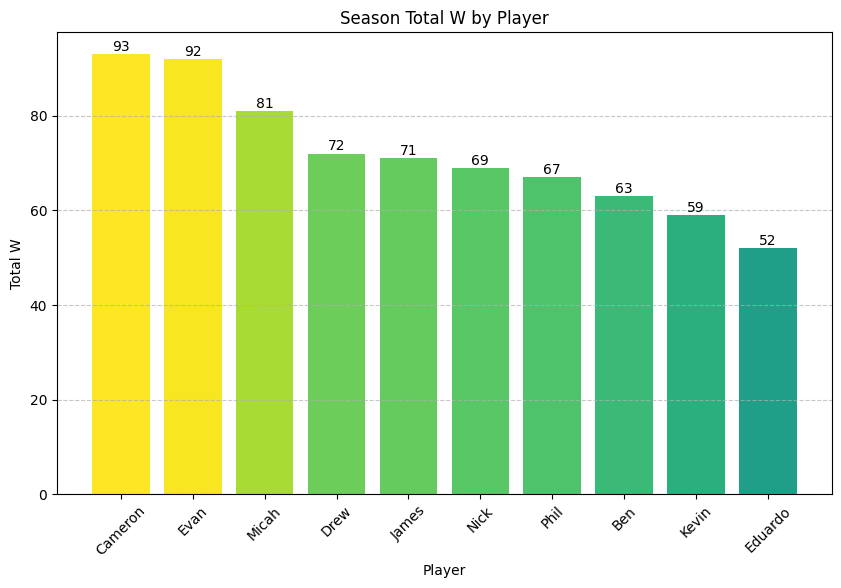

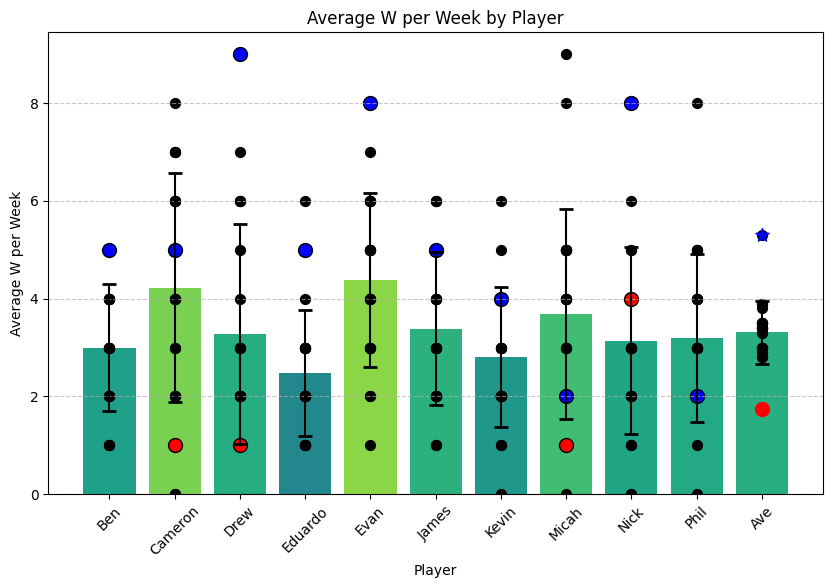

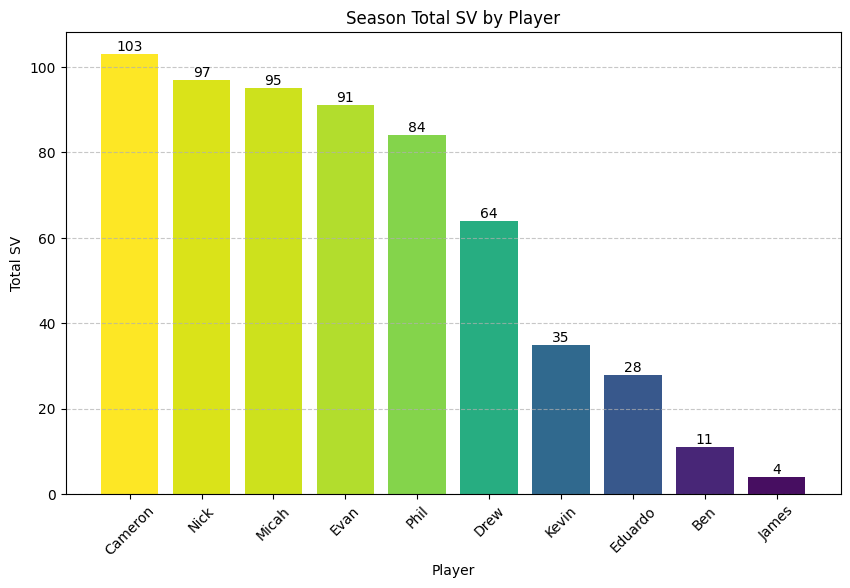

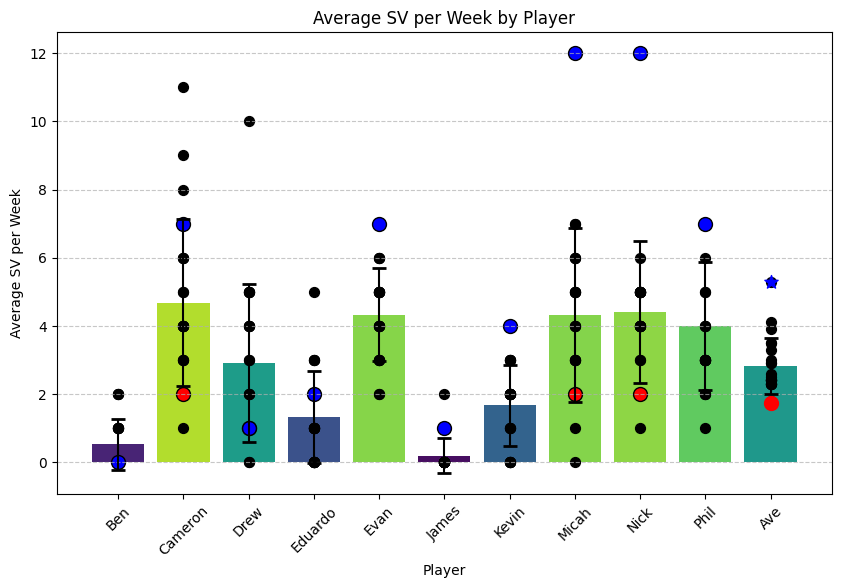

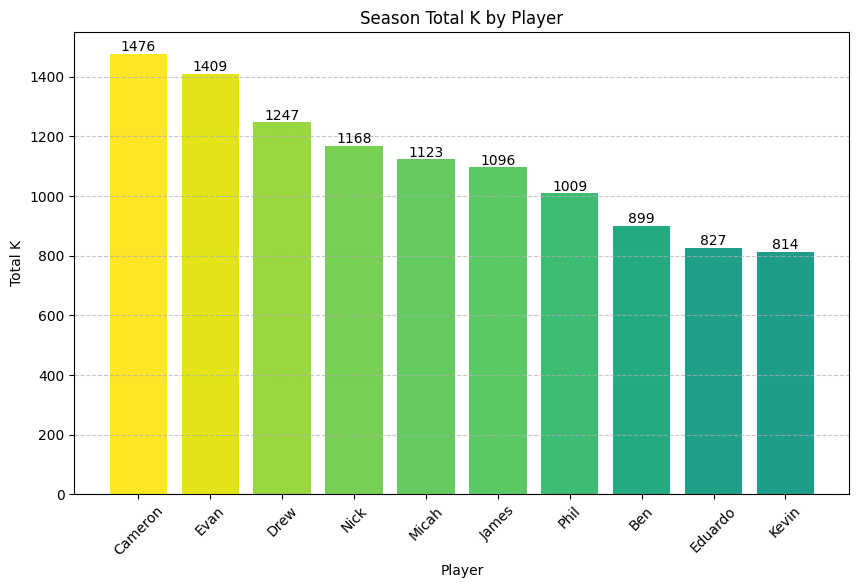

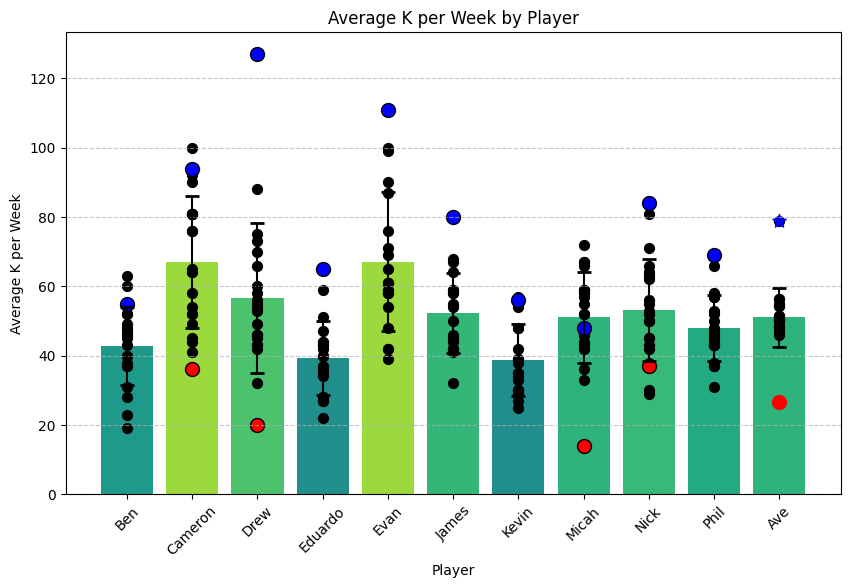

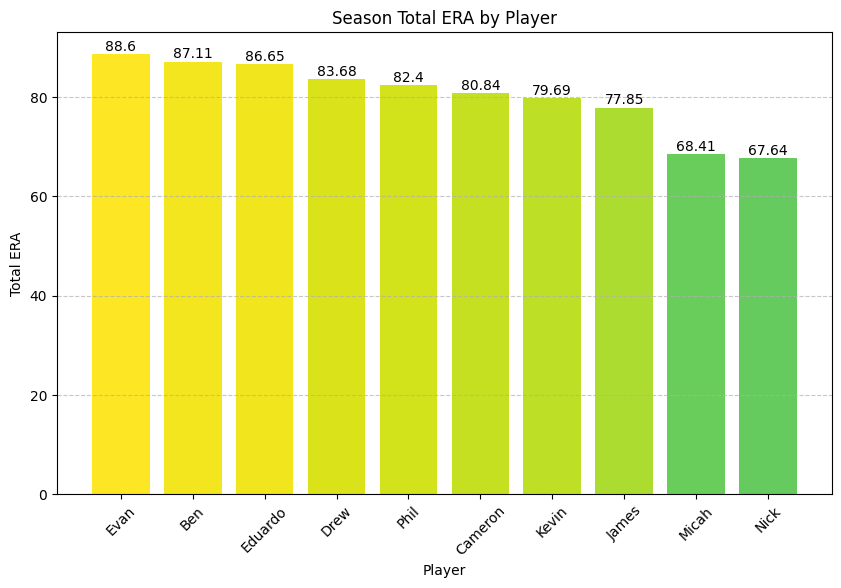

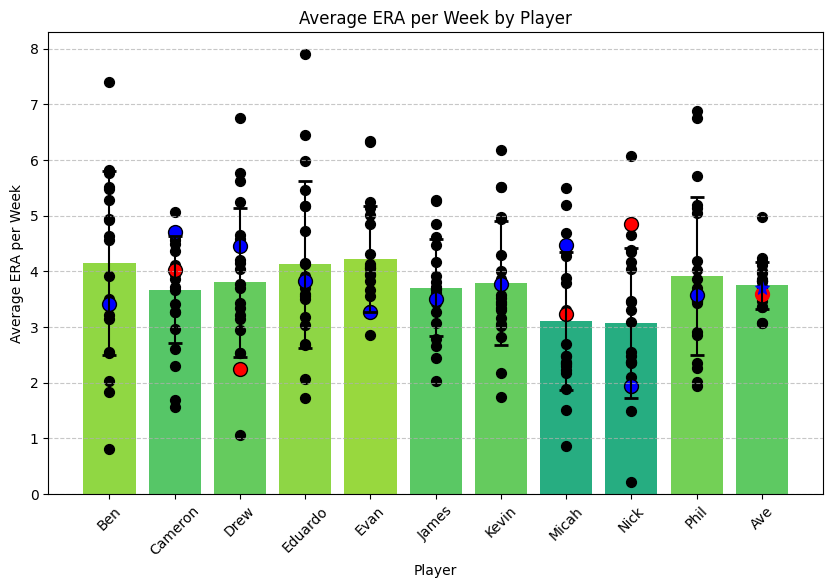

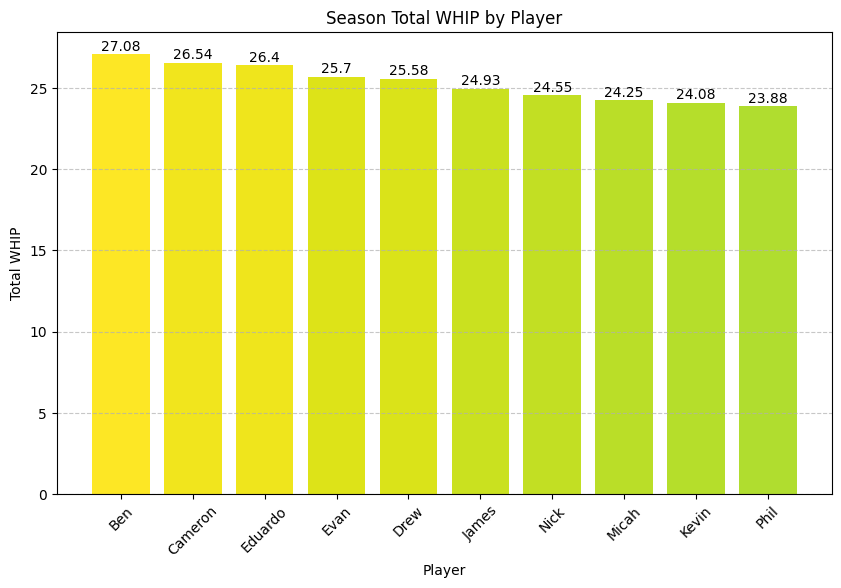

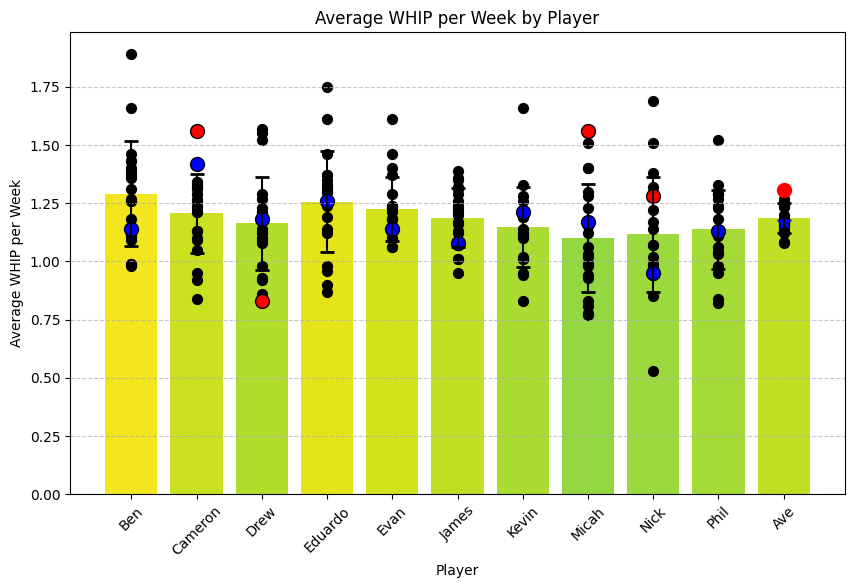

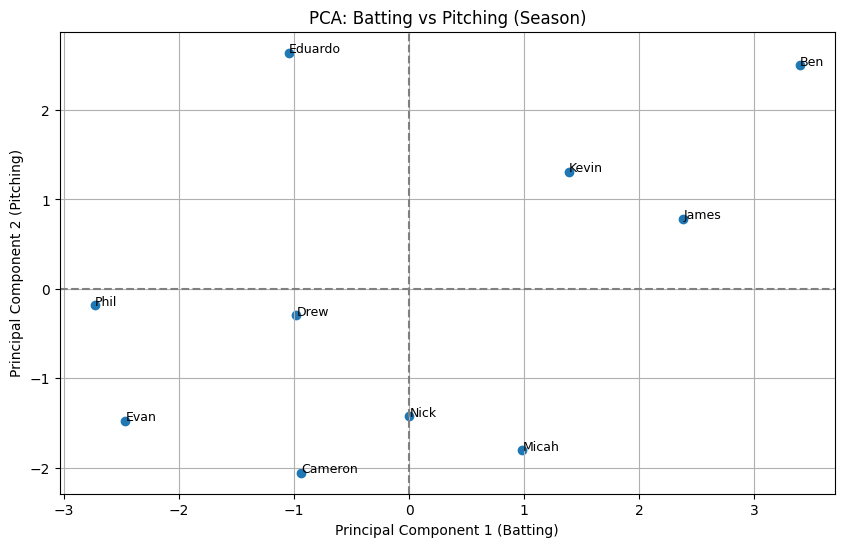

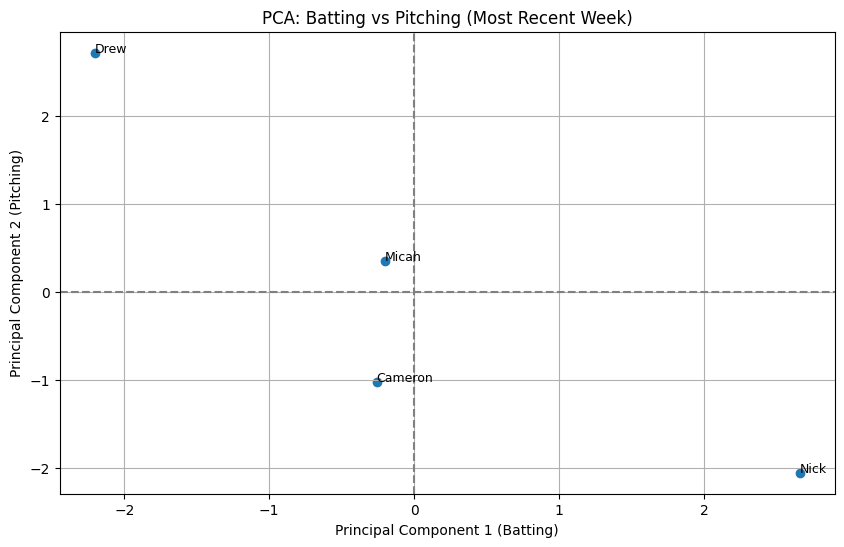

Head-to-head comparisons saved to head_to_head_comparisons.csv


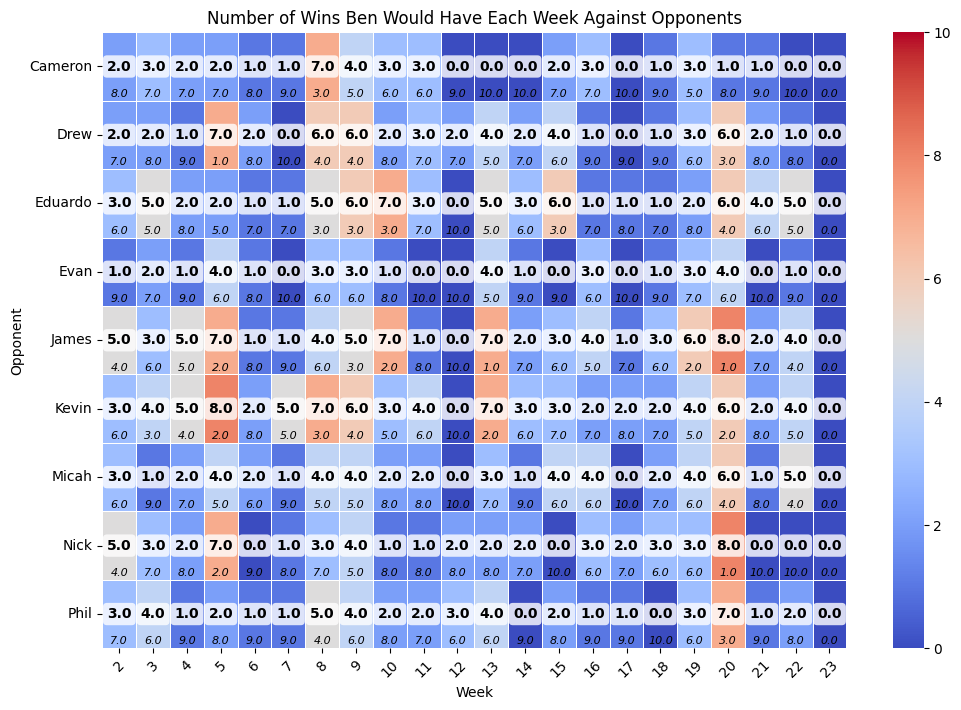

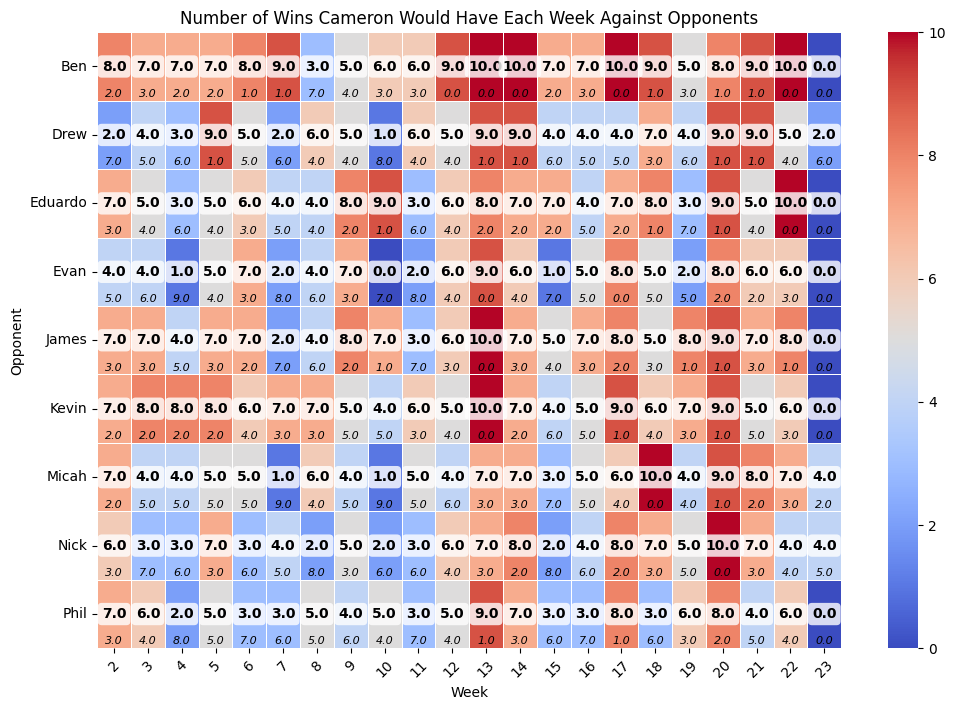

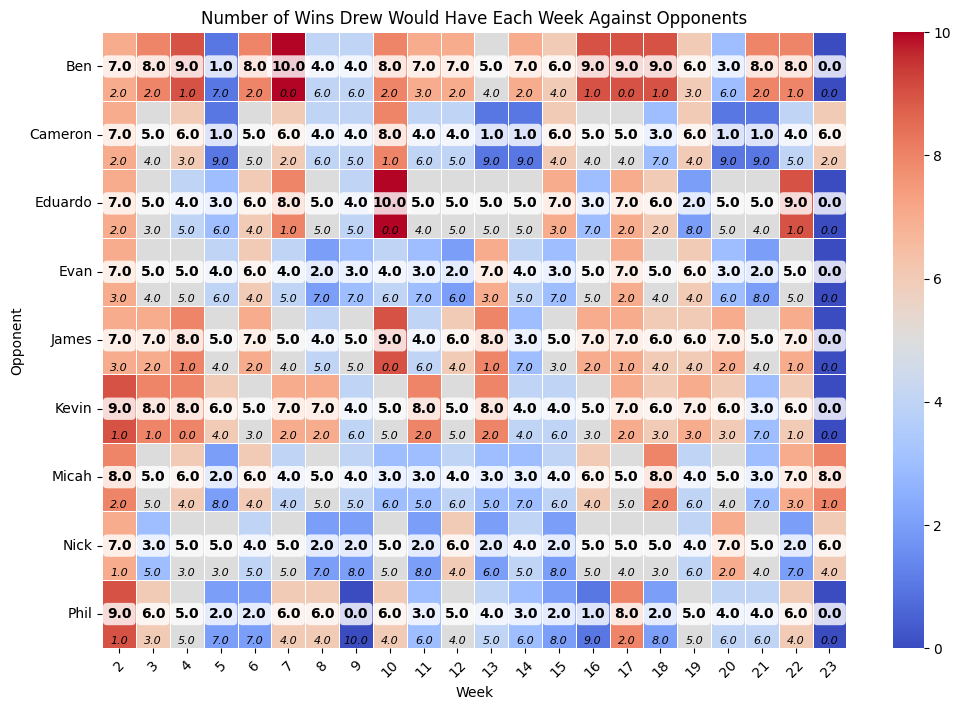

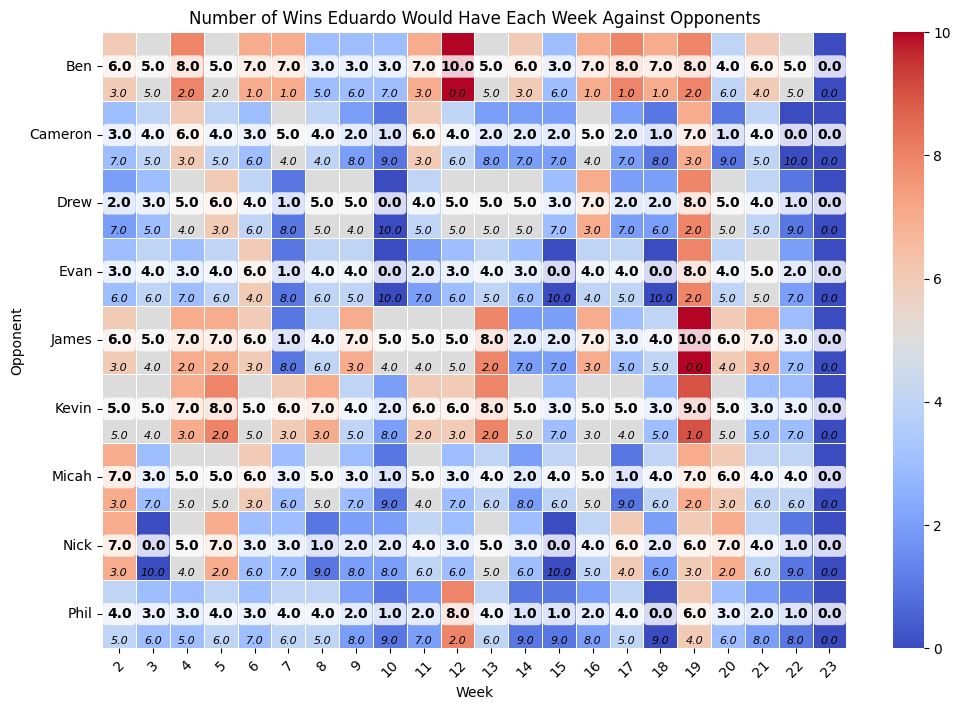

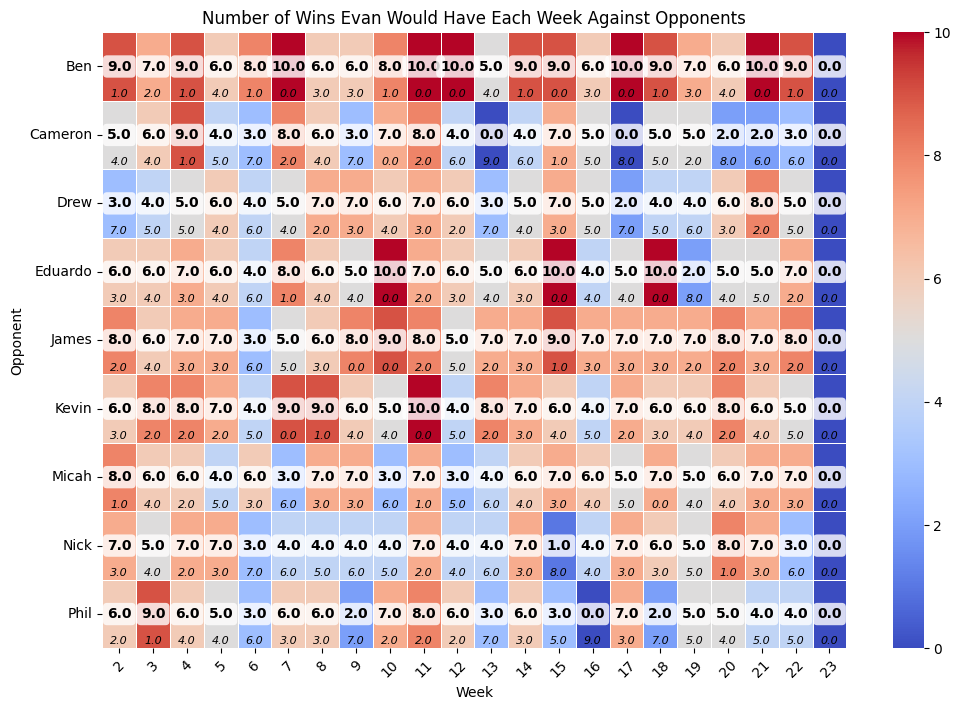

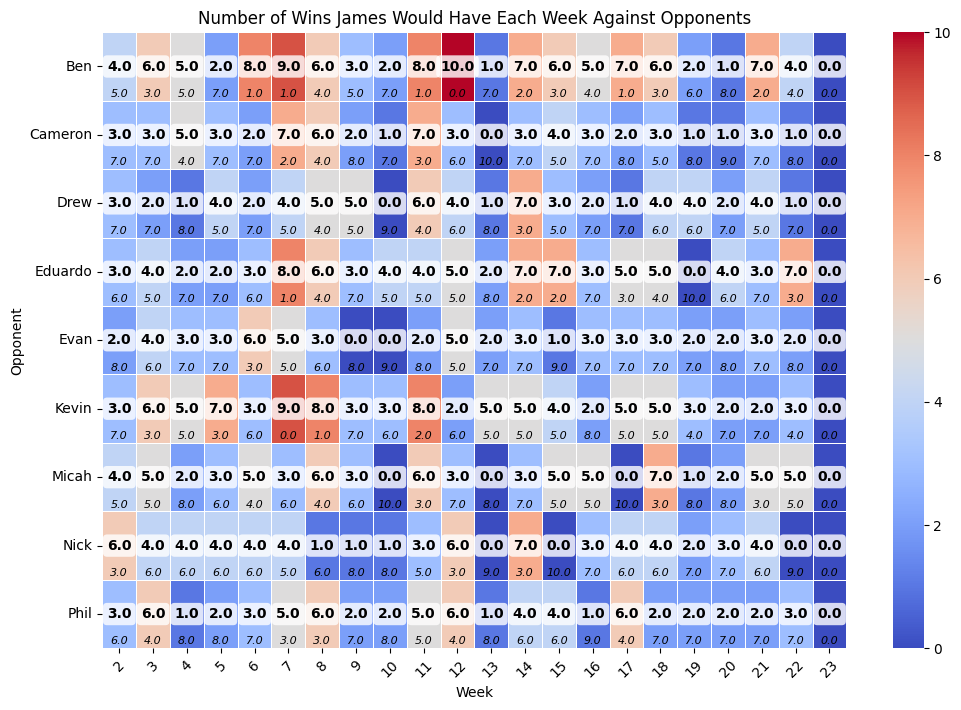

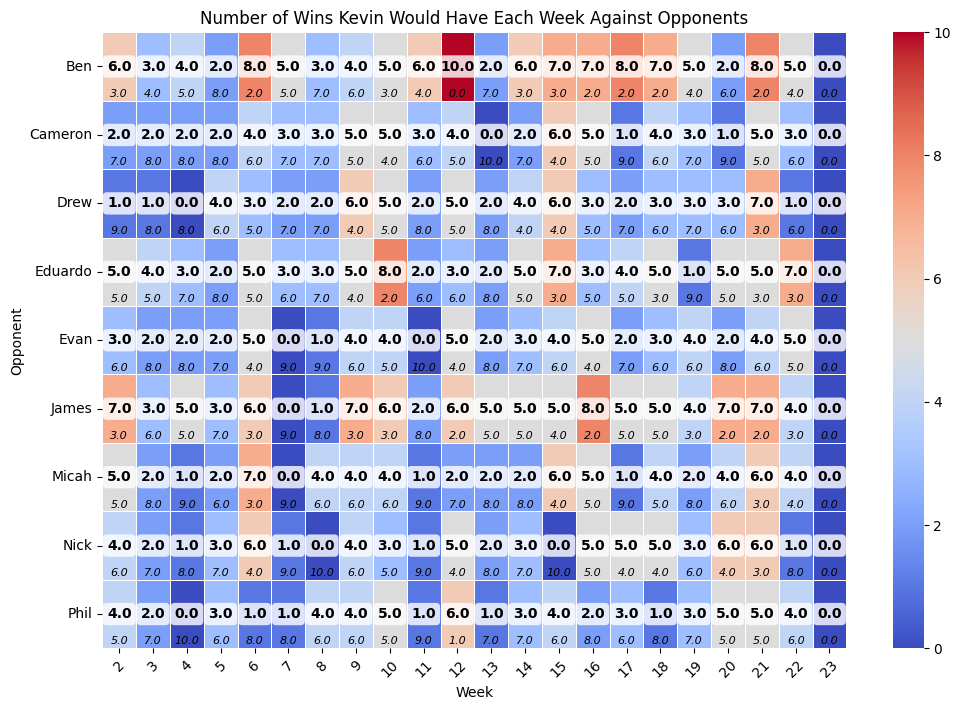

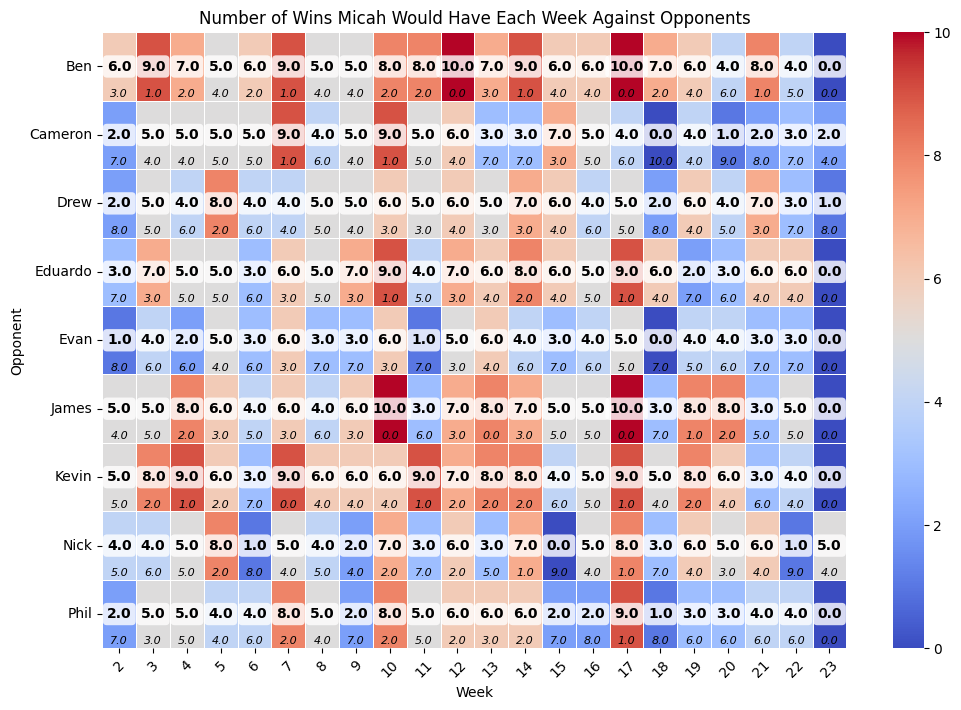

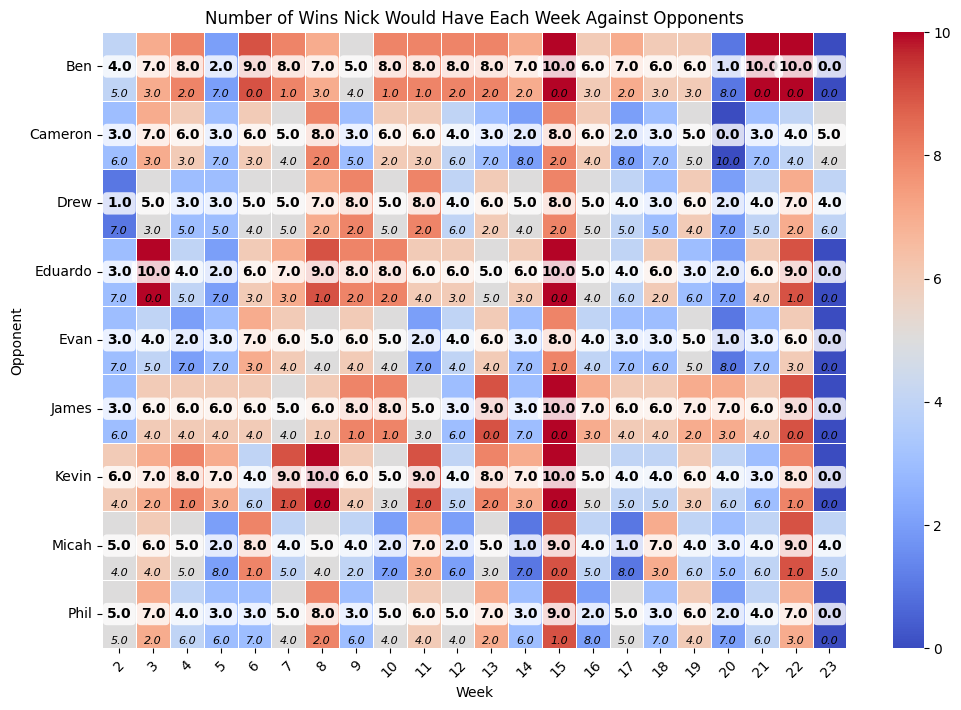

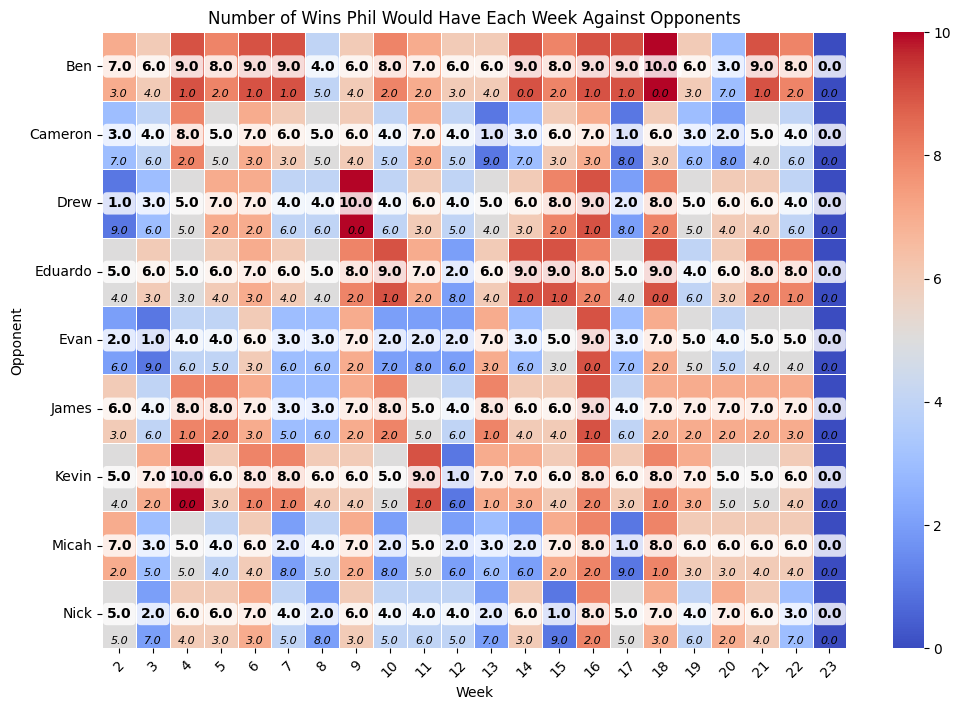

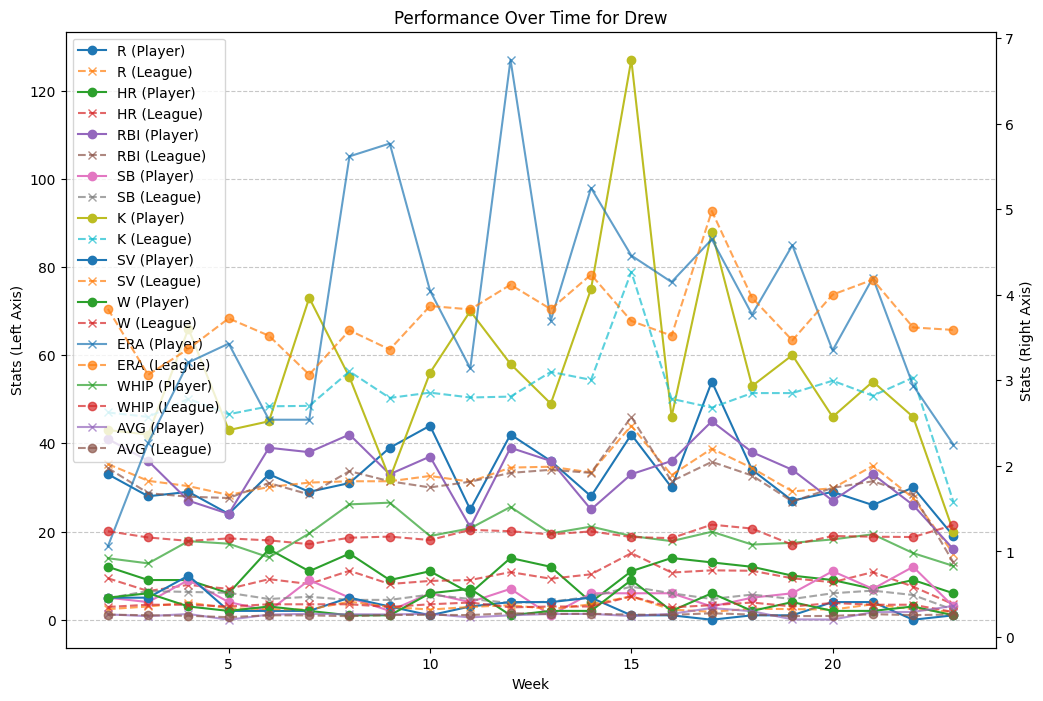

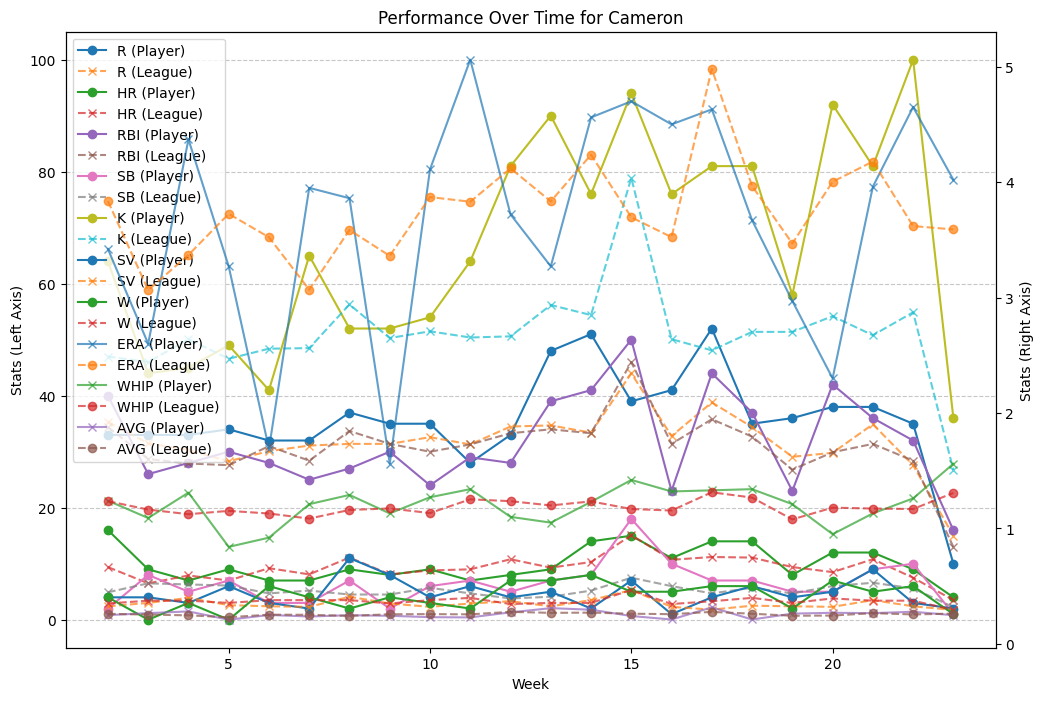

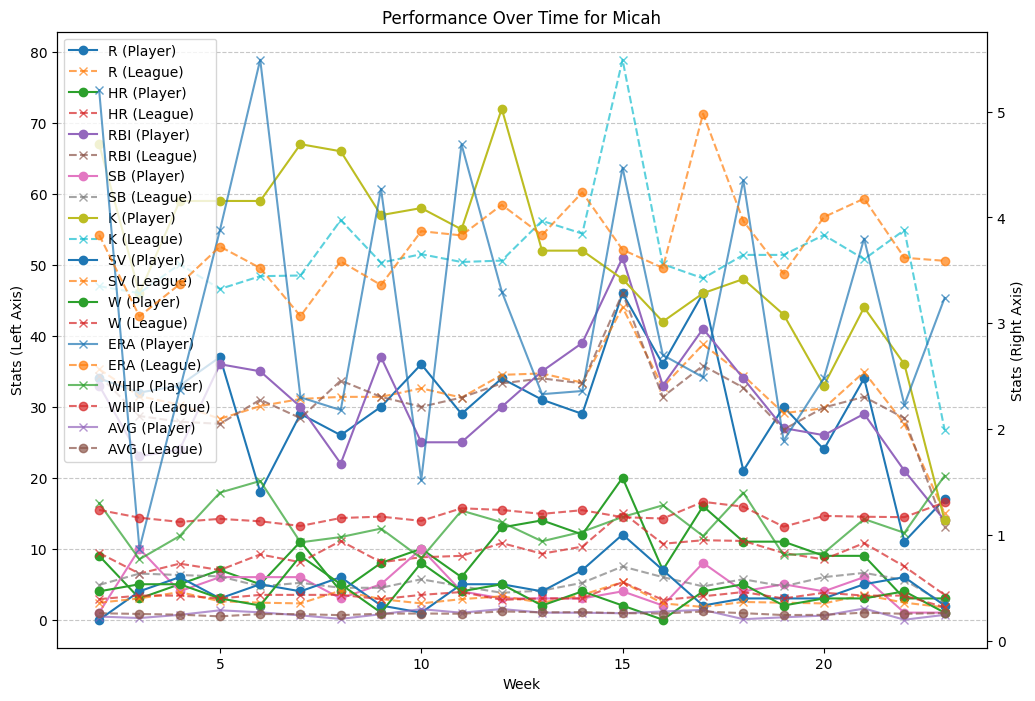

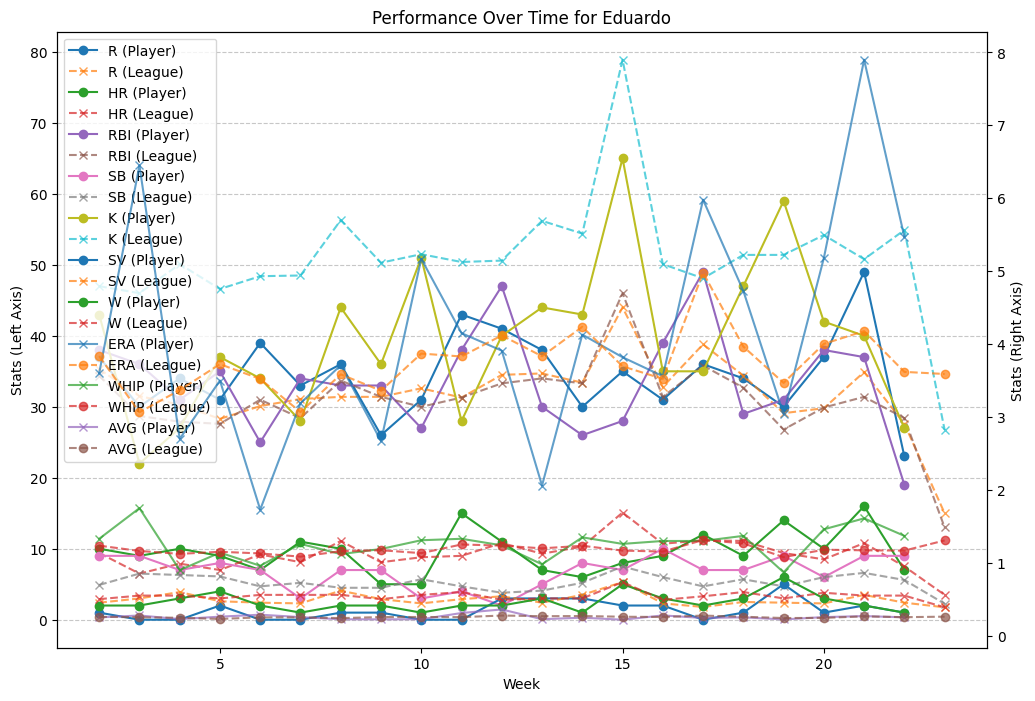

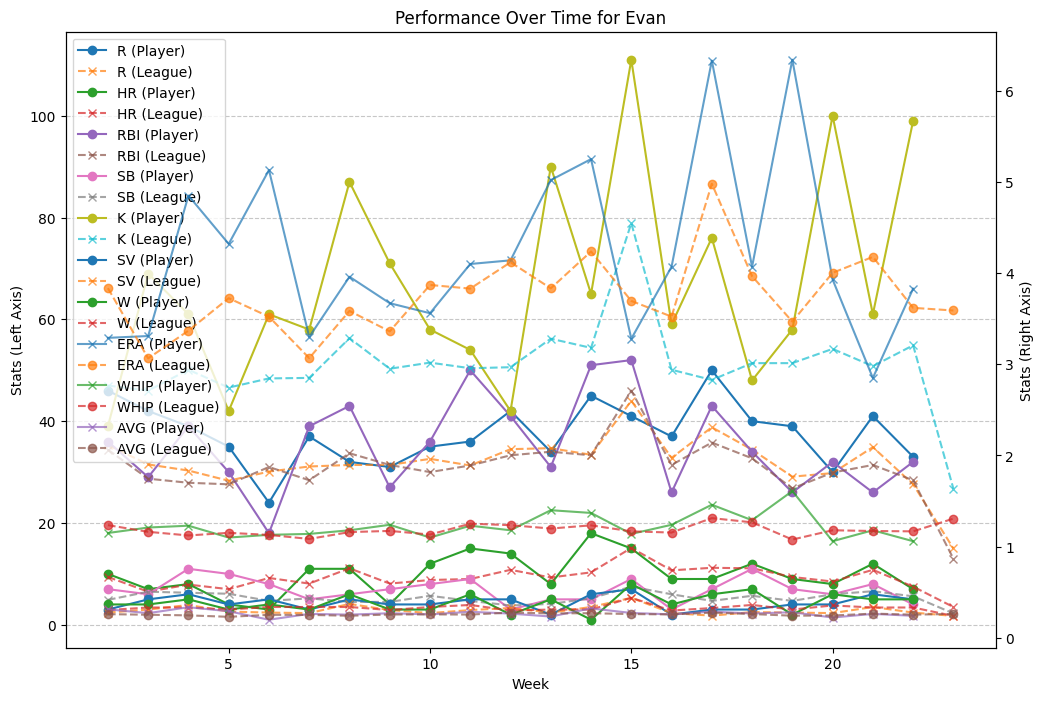

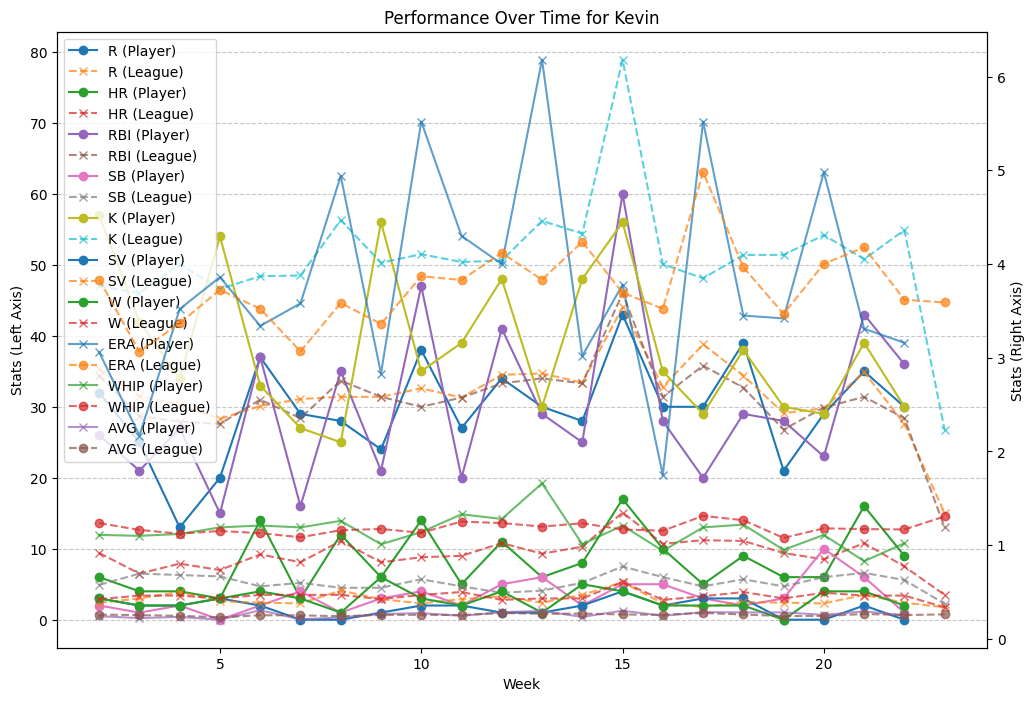

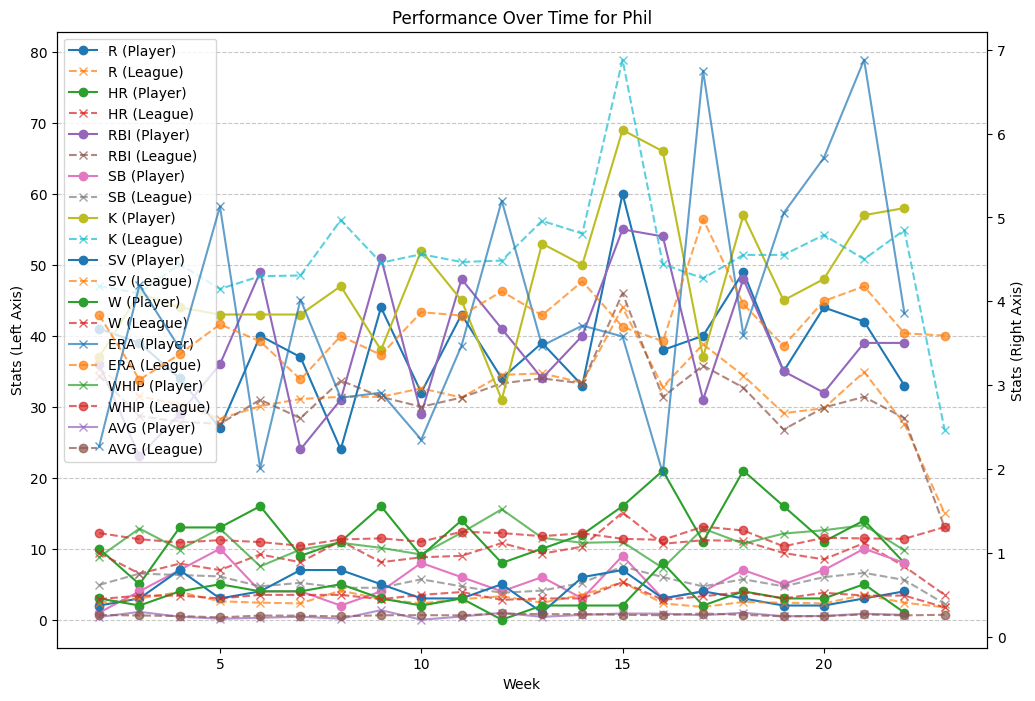

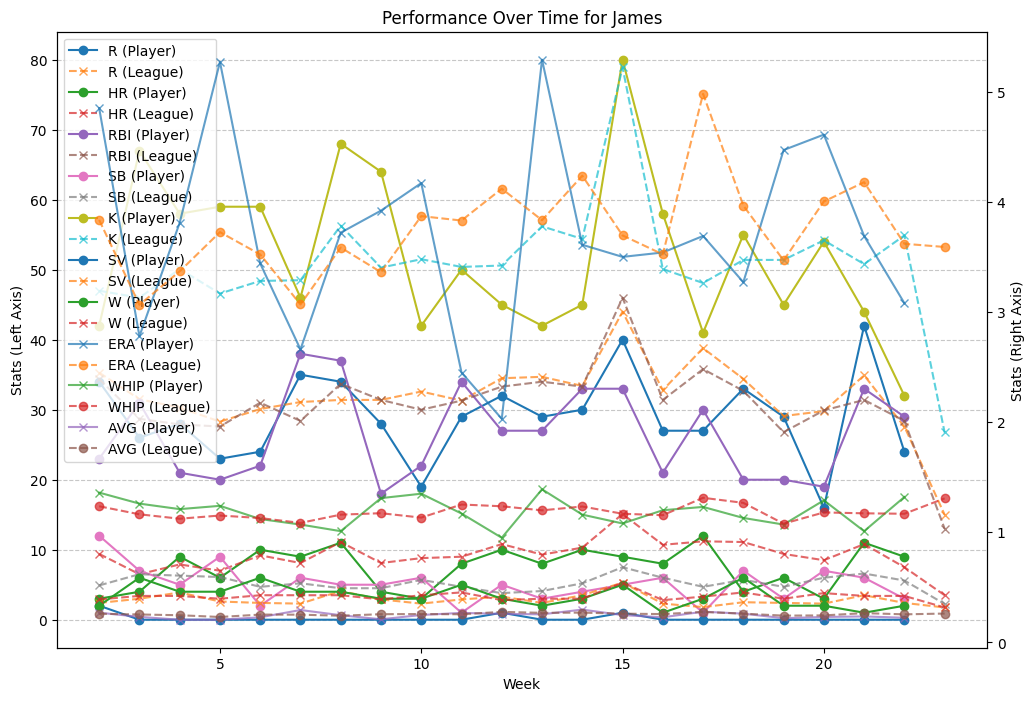

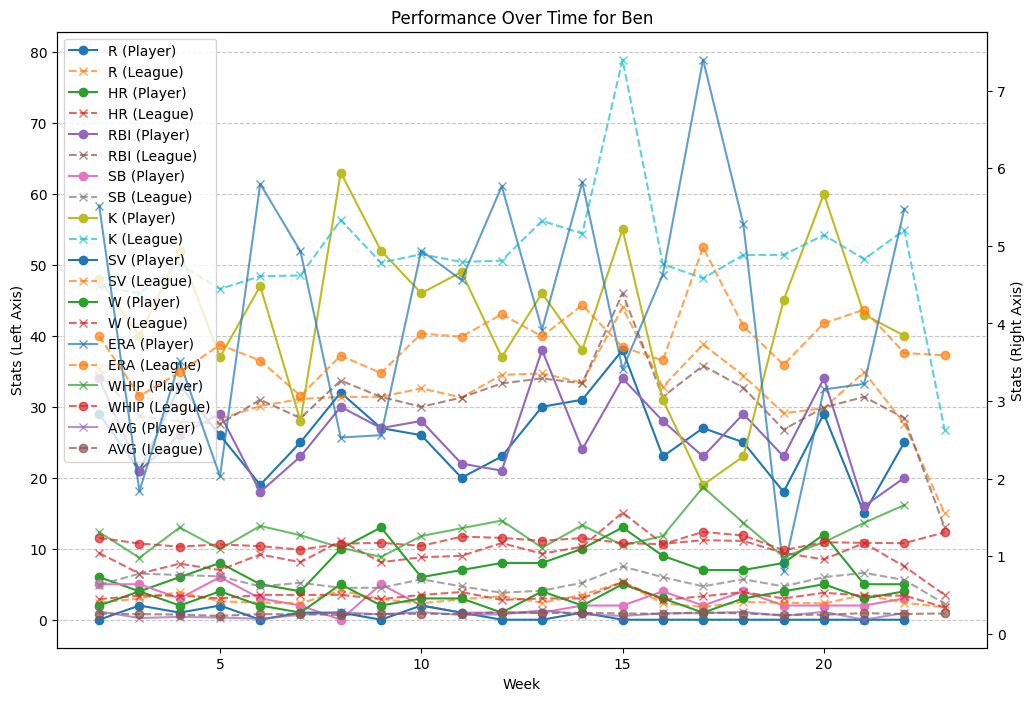

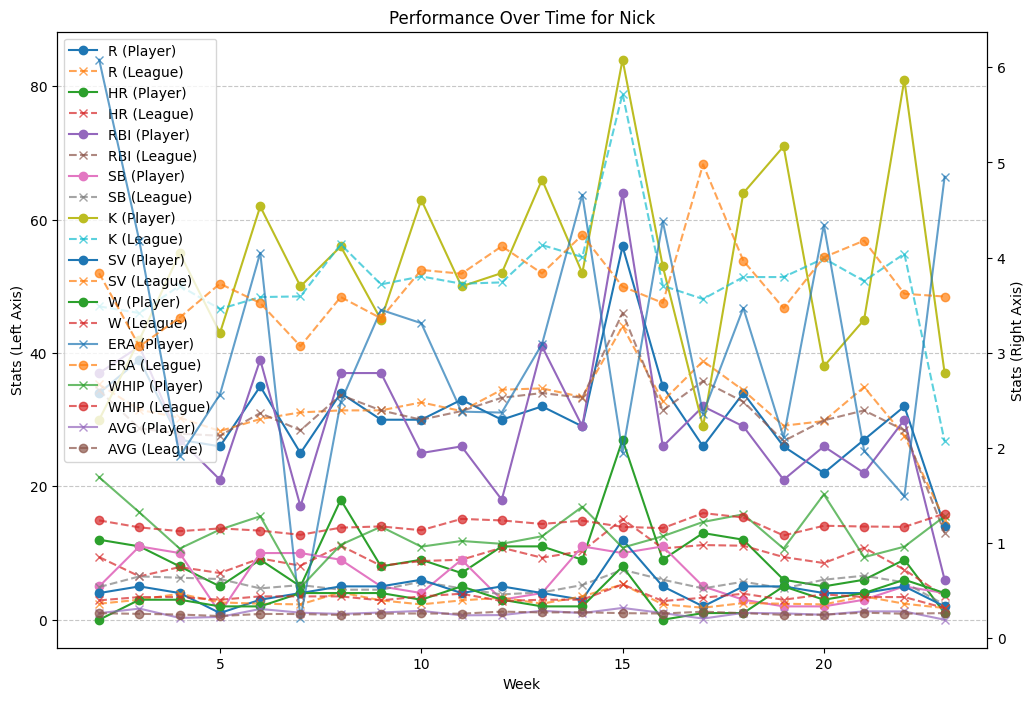

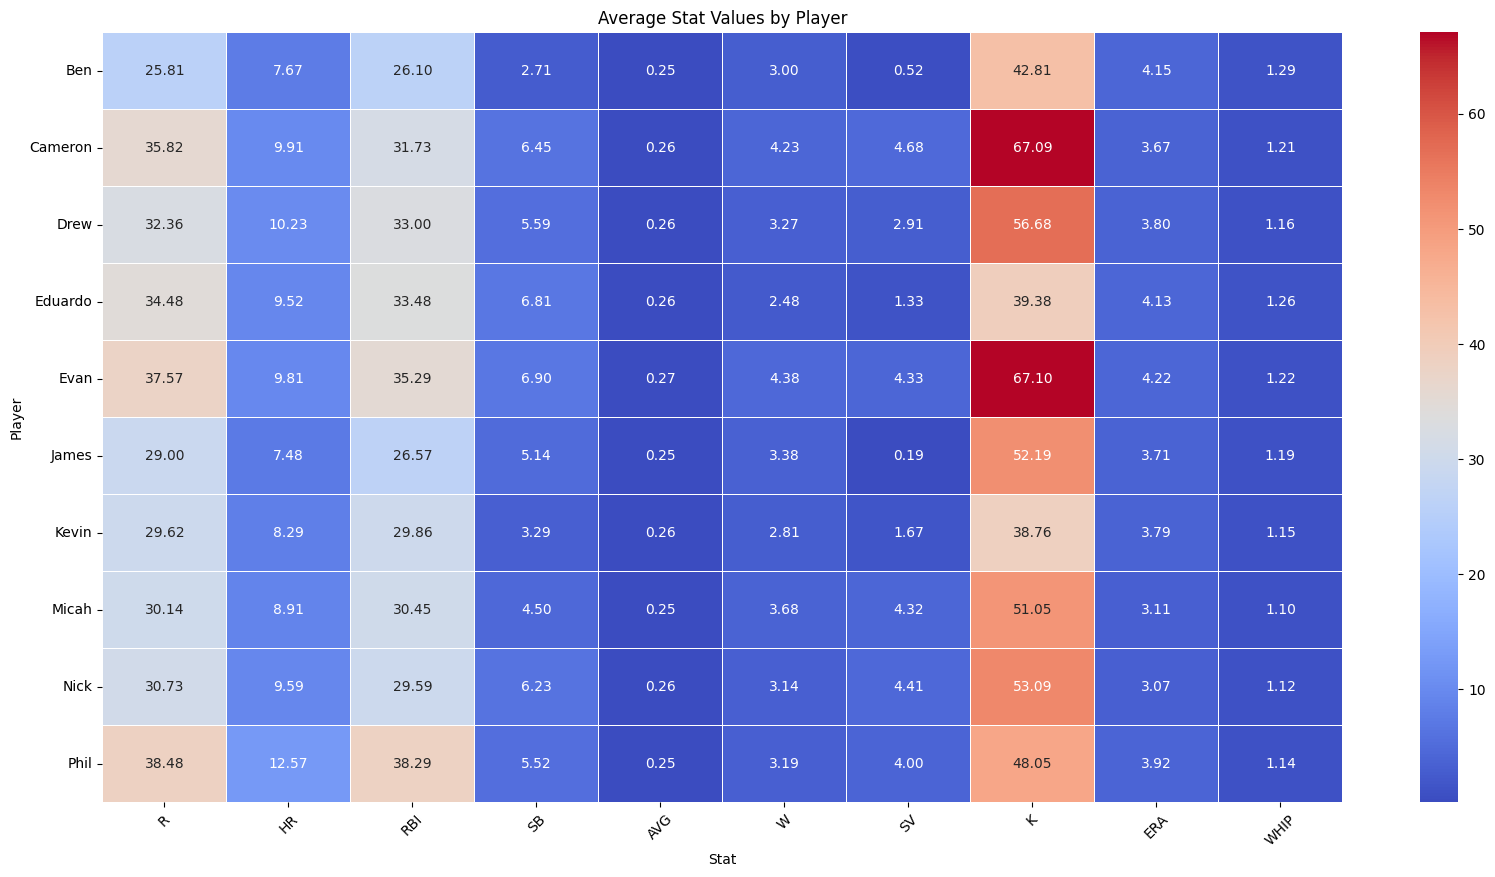

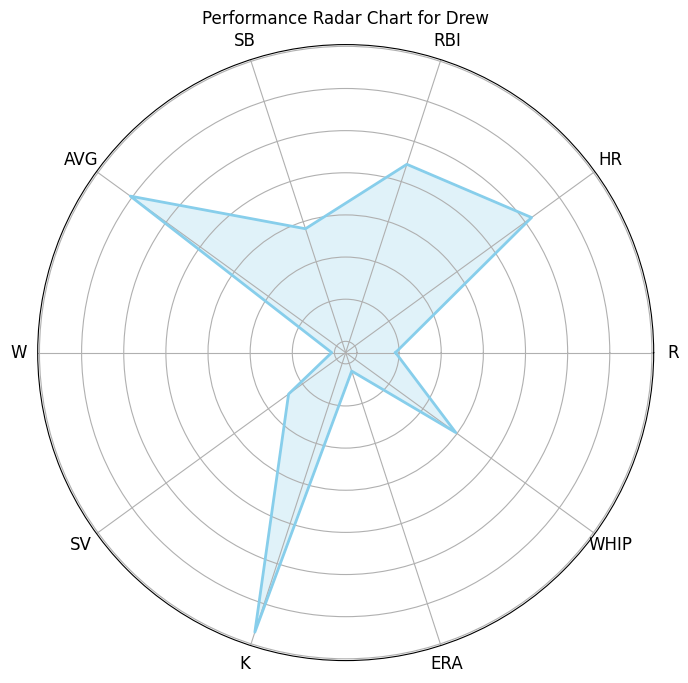

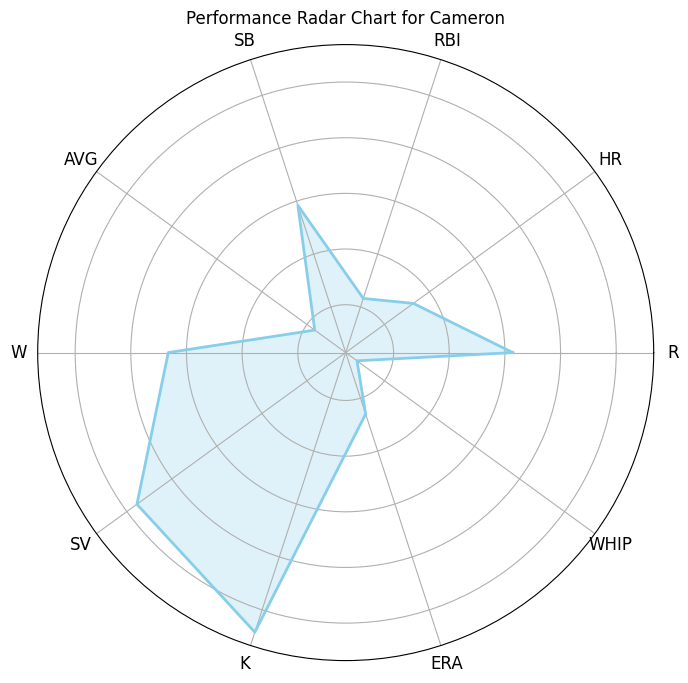

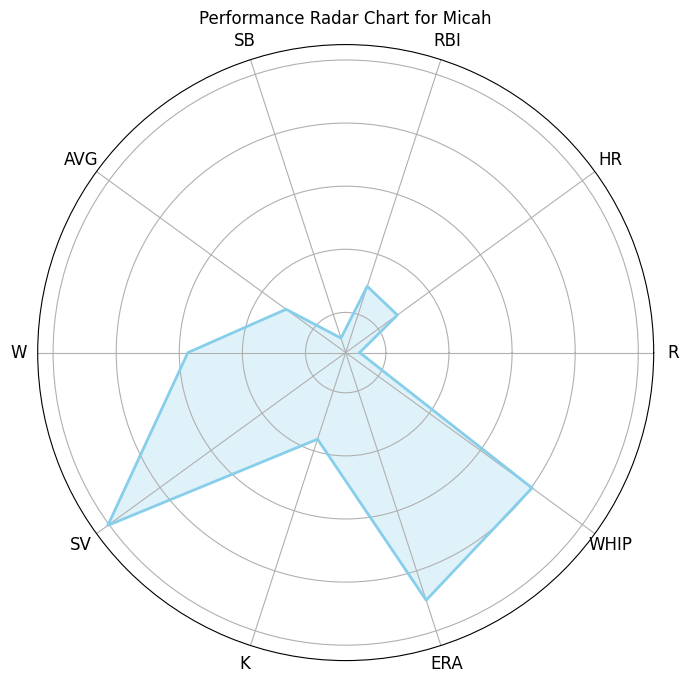

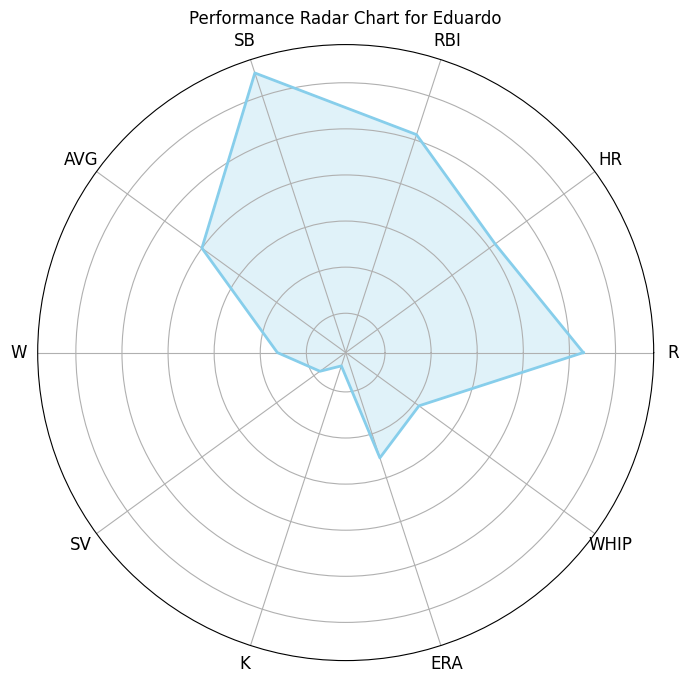

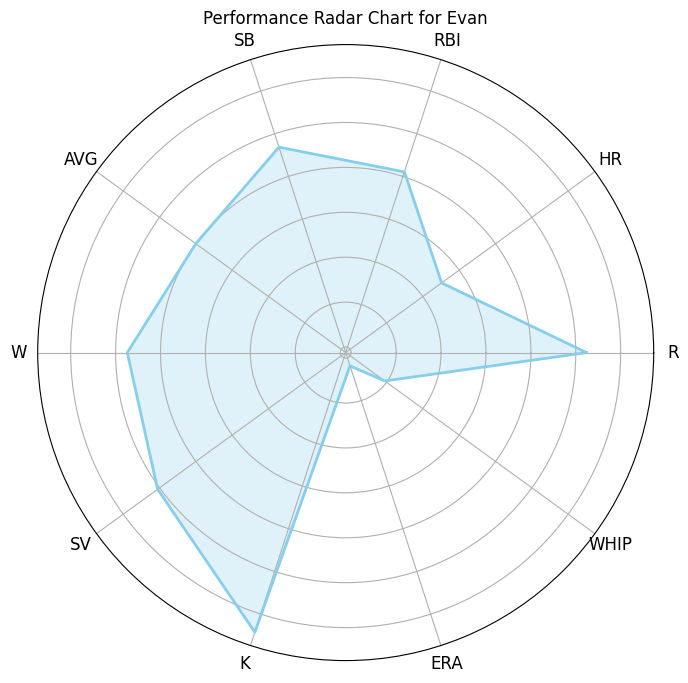

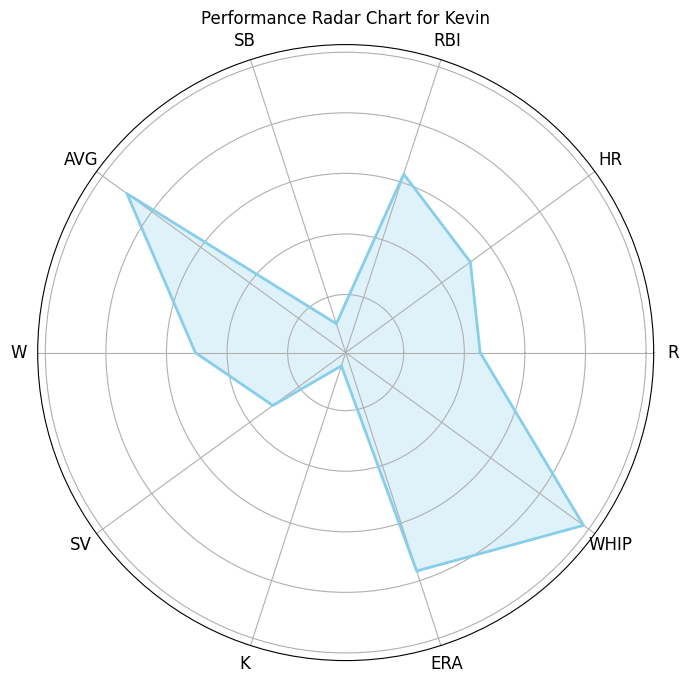

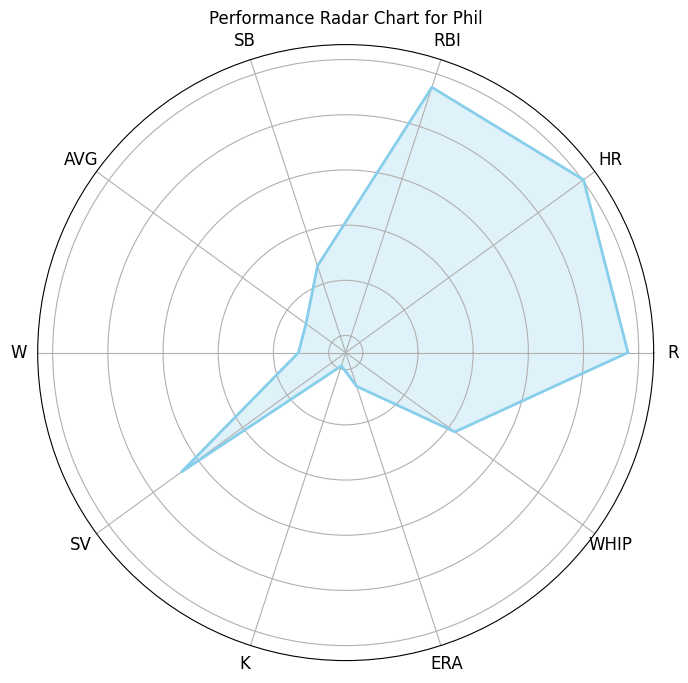

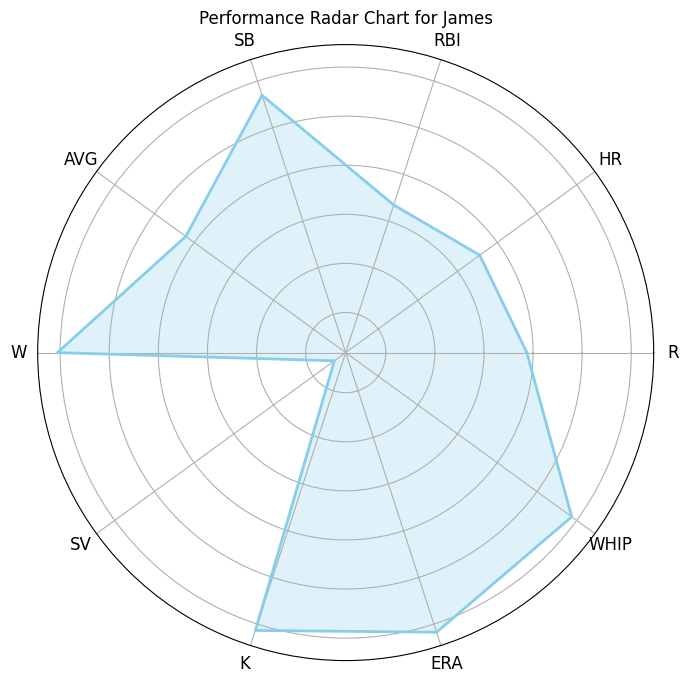

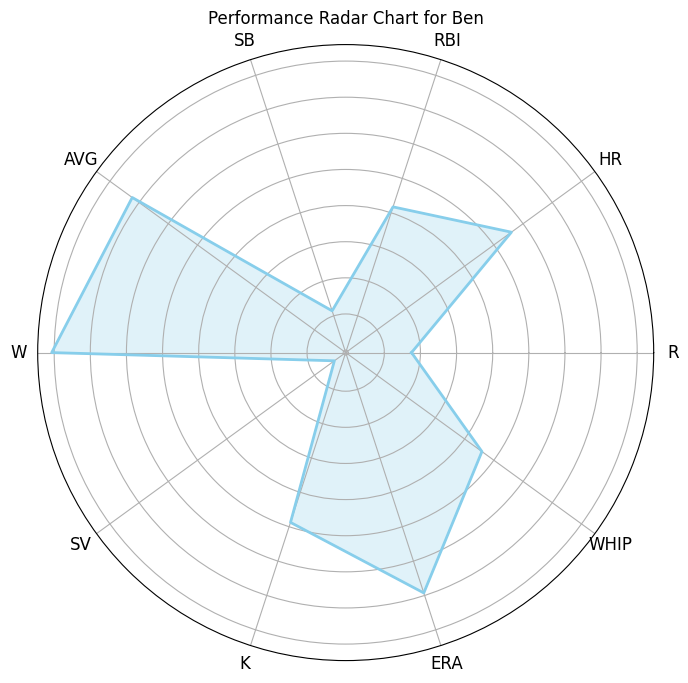

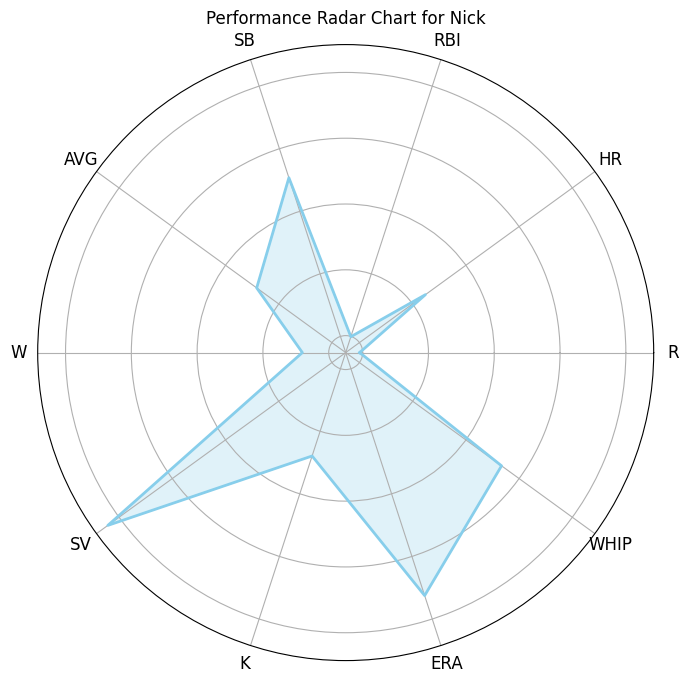

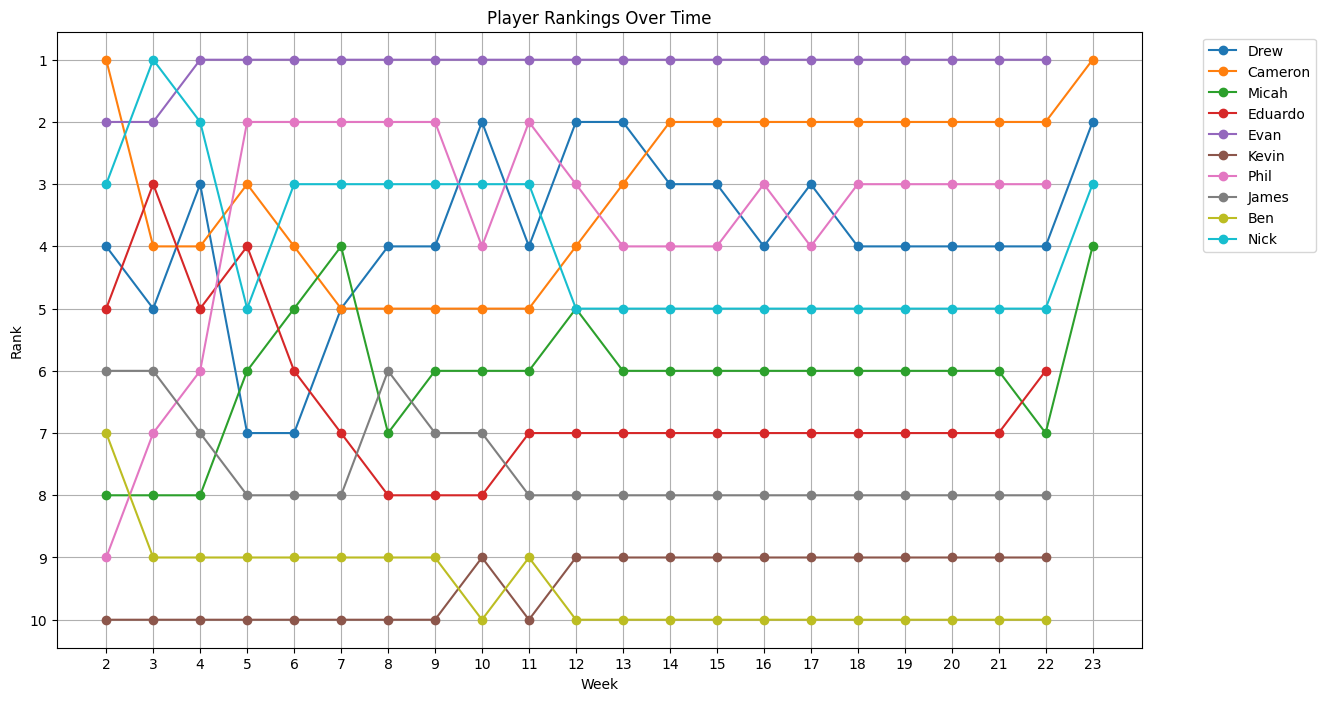

Ben:
  Strengths: 
  Weaknesses: R, HR, RBI, SB, AVG, W, SV, K, ERA, WHIP

Cameron:
  Strengths: R, HR, RBI, SB, W, SV, K, ERA
  Weaknesses: AVG, WHIP

Drew:
  Strengths: HR, RBI, SB, AVG, SV, K, WHIP
  Weaknesses: R, W, ERA

Eduardo:
  Strengths: R, HR, RBI, SB, AVG
  Weaknesses: W, SV, K, ERA, WHIP

Evan:
  Strengths: R, HR, RBI, SB, AVG, W, SV, K
  Weaknesses: ERA, WHIP

James:
  Strengths: W, K, ERA
  Weaknesses: R, HR, RBI, SB, AVG, SV, WHIP

Kevin:
  Strengths: AVG, WHIP
  Weaknesses: R, HR, RBI, SB, W, SV, K, ERA

Micah:
  Strengths: W, SV, ERA, WHIP
  Weaknesses: R, HR, RBI, SB, AVG, K

Nick:
  Strengths: HR, SB, AVG, SV, K, ERA, WHIP
  Weaknesses: R, RBI, W

Phil:
  Strengths: R, HR, RBI, SB, SV, WHIP
  Weaknesses: AVG, W, K, ERA



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Load and prepare data functions
def load_data(filepath):
    xls = pd.ExcelFile(filepath)
    df_list = []
    for sheet_name in xls.sheet_names:
        sheet_data = pd.read_excel(xls, sheet_name)
        sheet_data['Player'] = sheet_name
        sheet_data['Week'] = pd.to_numeric(sheet_data['Week'], errors='coerce')
        df_list.append(sheet_data)
    data = pd.concat(df_list, ignore_index=True)
    return data

# Function to calculate head-to-head points
def calculate_head_to_head_points(data):
    stats_columns = ['R', 'HR', 'RBI', 'SB', 'AVG', 'W', 'SV', 'K', 'ERA', 'WHIP']
    weekly_points = []

    for week in data['Week'].unique():
        weekly_data = data[data['Week'] == week]
        players = weekly_data['Player'].unique()
        week_points = {player: 0 for player in players}

        for stat in stats_columns:
            for i, player1 in enumerate(players):
                for j, player2 in enumerate(players):
                    if i >= j:  # Avoid duplicate comparisons and self-comparisons
                        continue
                    player1_stat = weekly_data[weekly_data['Player'] == player1][stat].values[0]
                    player2_stat = weekly_data[weekly_data['Player'] == player2][stat].values[0]

                    if stat in ['ERA', 'WHIP']:  # For these stats, lower is better
                        if player1_stat < player2_stat:
                            week_points[player1] += 1
                        elif player1_stat > player2_stat:
                            week_points[player2] += 1
                        else:
                            week_points[player1] += 0.5
                            week_points[player2] += 0.5
                    else:
                        if player1_stat > player2_stat:
                            week_points[player1] += 1
                        elif player1_stat < player2_stat:
                            week_points[player2] += 1
                        else:
                            week_points[player1] += 0.5
                            week_points[player2] += 0.5
        
        for player, points in week_points.items():
            weekly_points.append({'Player': player, 'Week': week, 'Points': points})

    return pd.DataFrame(weekly_points)


def prepare_clustering_data(data):
    metrics_to_show = ['R', 'HR', 'ERA', 'WHIP', 'RBI', 'SB', 'K', 'SV', 'W', 'AVG']
    numeric_data = data[['Player'] + metrics_to_show]
    aggregated_data = numeric_data.groupby('Player').mean()
    return aggregated_data

def filter_most_recent_week(data):
    most_recent_week = data['Week'].max()
    return data[data['Week'] == most_recent_week]

# PCA function
def run_pca(data, title_suffix=''):
    batting_stats = ['R', 'HR', 'RBI', 'SB', 'AVG']
    pitching_stats = ['W', 'SV', 'K', 'ERA', 'WHIP']
    player_stats = data.groupby('Player').mean(numeric_only=True).reset_index()
    batting_data = player_stats[batting_stats]
    pitching_data = player_stats[pitching_stats]
    imputer = SimpleImputer(strategy='mean')
    batting_data_imputed = imputer.fit_transform(batting_data)
    pitching_data_imputed = imputer.fit_transform(pitching_data)
    scaler = StandardScaler()
    batting_data_scaled = scaler.fit_transform(batting_data_imputed)
    pitching_data_scaled = scaler.fit_transform(pitching_data_imputed)
    pca_batting = PCA(n_components=1)
    pca_pitching = PCA(n_components=1)
    pc1_batting = pca_batting.fit_transform(batting_data_scaled)
    pc2_pitching = pca_pitching.fit_transform(pitching_data_scaled)
    pca_results = pd.DataFrame({
        'Player': player_stats['Player'], 
        'PC1_Batting': pc1_batting.flatten(), 
        'PC2_Pitching': pc2_pitching.flatten()
    })
    pca_results['PCA_Type'] = title_suffix
    return pca_results

# Plotting functions
def plot_pca(pca_results):
    plt.figure(figsize=(10, 6))
    plt.scatter(pca_results['PC1_Batting'], pca_results['PC2_Pitching'])
    plt.axhline(0, color='grey', linestyle='--')
    plt.axvline(0, color='grey', linestyle='--')
    for _, row in pca_results.iterrows():
        plt.text(row['PC1_Batting'], row['PC2_Pitching'], row['Player'], fontsize=9)
    plt.xlabel('Principal Component 1 (Batting)')
    plt.ylabel('Principal Component 2 (Pitching)')
    plt.title(f'PCA: Batting vs Pitching ({pca_results["PCA_Type"].iloc[0]})')
    plt.grid(True)
    plt.savefig(f'PCA_Batting_vs_Pitching_{pca_results["PCA_Type"].iloc[0]}.png')
    plt.show()

def plot_stat(data, stat):
    data = data.dropna(subset=[stat])
    if stat == 'AVG':
        season_totals = data.groupby('Player')[stat].mean().reset_index().sort_values(by=stat, ascending=False)
    else:
        season_totals = data.groupby('Player')[stat].sum().reset_index().sort_values(by=stat, ascending=False)
    max_value = season_totals[stat].max()
    fig, ax = plt.subplots(figsize=(10, 6))
    norm = Normalize(0, max_value)
    cmap = ScalarMappable(norm=norm, cmap='viridis')
    bars = ax.bar(season_totals['Player'], season_totals[stat], color=[cmap.to_rgba(x) for x in season_totals[stat]])
    
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 3 if stat == 'AVG' else 2), ha='center', va='bottom')
    
    ax.set_title(f'Season Total {stat} by Player')
    ax.set_xlabel('Player')
    ax.set_ylabel(f'Total {stat}')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig(f'{stat}_season_total.png')
    plt.show()
    plt.close()

def plot_average_stat(data, stat):
    data = data.dropna(subset=['Week', stat])
    weekly_data = data.groupby(['Player', 'Week'])[stat].mean().reset_index()
    weekly_avg_std = weekly_data.groupby('Player')[stat].agg(['mean', 'std'])
    league_weekly_avg = data.groupby('Week')[stat].mean().reset_index()
    max_value = max(weekly_avg_std['mean'].max(), league_weekly_avg[stat].max())
    min_value = min(weekly_avg_std['mean'].min(), league_weekly_avg[stat].min())
    fig, ax = plt.subplots(figsize=(10, 6))
    norm = Normalize(0, max_value)
    cmap = ScalarMappable(norm=norm, cmap='viridis')
    bars = ax.bar(weekly_avg_std.index, weekly_avg_std['mean'], yerr=weekly_avg_std['std'],
                  color=[cmap.to_rgba(x) for x in weekly_avg_std['mean']], capsize=5,
                  error_kw={'ecolor': 'black', 'capthick': 2})
    league_avg_mean = league_weekly_avg[stat].mean()
    league_avg_std_dev = league_weekly_avg[stat].std()
    league_color = cmap.to_rgba(league_avg_mean)
    ax.bar('Ave', league_avg_mean, yerr=league_avg_std_dev, color=league_color, capsize=5, error_kw={'ecolor': 'black', 'capthick': 2})
    for week in league_weekly_avg['Week']:
        avg_value = league_weekly_avg[league_weekly_avg['Week'] == week][stat].values[0]
        ax.scatter(['Ave'], avg_value, color='black', s=50)
    most_recent_week = league_weekly_avg['Week'].max()
    most_recent_league_avg = league_weekly_avg[league_weekly_avg['Week'] == most_recent_week][stat].values[0]
    ax.scatter('Ave', most_recent_league_avg, color='red', s=100, edgecolor='red', marker='o')
    week_15_avg = league_weekly_avg[league_weekly_avg['Week'] == 15][stat].values[0]
    ax.scatter('Ave', week_15_avg, color='blue', s=100, edgecolor='blue', marker='*')
    for i, player in enumerate(weekly_avg_std.index):
        player_data = weekly_data[weekly_data['Player'] == player]
        ax.scatter([i] * len(player_data), player_data[stat], color='black', s=50)
        most_recent_data = player_data[player_data['Week'] == most_recent_week]
        if not most_recent_data.empty:
            ax.scatter(i, most_recent_data[stat].values[0], color='red', s=100, edgecolor='black', marker='o')
        week_15_data = player_data[player_data['Week'] == 15]
        if not week_15_data.empty:
            ax.scatter(i, week_15_data[stat].values[0], color='blue', s=100, edgecolor='black', marker='o')
    ax.set_title(f'Average {stat} per Week by Player')
    ax.set_xlabel('Player')
    ax.set_ylabel(f'Average {stat} per Week')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    if stat == 'AVG':
        ax.set_ylim(0.15, 0.4)
    #if stat == 'K':
        #ax.axhspan(70, 80, color='brown', alpha=0.3, label='Bronze (70-80)')
        #ax.axhspan(80, 90, color='silver', alpha=0.3, label='Silver (80-90)')
        #ax.axhspan(90, 100, color='gold', alpha=0.3, label='Gold (90-100)')
    plt.savefig(f'{stat}_average_per_week.png')
    plt.show()
    plt.close()
    
    
def head_to_head_comparison(data, stats):
    weekly_data = data.groupby(['Player', 'Week'])[stats].mean().reset_index()
    players = weekly_data['Player'].unique()
    weeks = weekly_data['Week'].unique()
    results = []
    for week in weeks:
        week_data = weekly_data[weekly_data['Week'] == week]
        for player1 in players:
            for player2 in players:
                if player1 != player2:
                    player1_data = week_data[week_data['Player'] == player1][stats].values.flatten()
                    player2_data = week_data[week_data['Player'] == player2][stats].values.flatten()
                    comparison = []
                    for stat, p1_val, p2_val in zip(stats, player1_data, player2_data):
                        if stat in ['WHIP', 'ERA']:
                            if p1_val < p2_val:
                                comparison.append(1)
                            elif p1_val > p2_val:
                                comparison.append(-1)
                            else:
                                comparison.append(0)
                        else:
                            if p1_val > p2_val:
                                comparison.append(1)
                            elif p1_val < p2_val:
                                comparison.append(-1)
                            else:
                                comparison.append(0)
                    win = comparison.count(1)
                    results.append({
                        'Week': week,
                        'Player1': player1,
                        'Player2': player2,
                        'Wins': win
                    })
    results_df = pd.DataFrame(results)
    results_df.to_csv('head_to_head_comparisons.csv', index=False)
    print('Head-to-head comparisons saved to head_to_head_comparisons.csv')
    return results_df

import matplotlib.patches as patches

def visualize_head_to_head(results_df):
    players = results_df['Player1'].unique()
    for player in players:
        player_df = results_df[results_df['Player1'] == player].pivot_table(index='Player2', columns='Week', values='Wins')
        
        # Prepare a DataFrame to include opponent's scores
        opponent_scores_df = results_df[results_df['Player2'] == player].pivot_table(index='Player1', columns='Week', values='Wins')
        opponent_scores_df = opponent_scores_df.reindex(index=player_df.index, columns=player_df.columns)
        
        plt.figure(figsize=(12, 8))
        ax = sns.heatmap(player_df, annot=False, fmt=".1f", cmap='coolwarm', linewidths=.5, cbar=True, vmin=0, vmax=10)

        for (i, j), val in np.ndenumerate(player_df):
            opponent_val = opponent_scores_df.iat[i, j]
            # Main text
            plt.text(j + 0.5, i + 0.5, f'{val:.1f}', ha='center', va='center',
                     fontsize=10, weight='bold', color='black',
                     bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='white', alpha=0.8))
            # Opponent's score
            plt.text(j + 0.5, i + 0.9, f'{opponent_val:.1f}', ha='center', va='center',
                     fontsize=8, weight='light', color='black', style='italic')
            
            # Add a rectangle around the cell
            #rect = patches.Rectangle((j, i), 1, 1, linewidth=2, edgecolor='black', facecolor='none')
           # ax.add_patch(rect)
        
        plt.title(f'Number of Wins {player} Would Have Each Week Against Opponents')
        plt.xlabel('Week')
        plt.ylabel('Opponent')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.savefig(f'weekly_head_to_head_heatmap_{player}.png')
        plt.show()
        
# Function to plot player rankings over time
def plot_player_rankings(data):
    points_data = calculate_head_to_head_points(data)
    
    # Calculate cumulative points
    points_data['CumulativePoints'] = points_data.groupby('Player')['Points'].cumsum()
    
    # Calculate ranks based on cumulative points
    points_data['Rank'] = points_data.groupby('Week')['CumulativePoints'].rank(ascending=False, method='min')

    plt.figure(figsize=(14, 8))
    for player in points_data['Player'].unique():
        player_data = points_data[points_data['Player'] == player]
        plt.plot(player_data['Week'], player_data['Rank'], marker='o', label=player)

    plt.gca().invert_yaxis()  # Inverting y-axis to have rank 1 at the top
    plt.title('Player Rankings Over Time')
    plt.xlabel('Week')
    plt.ylabel('Rank')
    plt.xticks(points_data['Week'].unique())
    plt.yticks(range(1, int(points_data['Rank'].max()) + 1))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()
    
def plot_performance_over_time(data, stats):
    players = data['Player'].unique()
    league_average = data.groupby('Week')[stats].mean().reset_index()
    
    for player in players:
        fig, ax1 = plt.subplots(figsize=(12, 8))

        # Define two sets of stats: one for the left y-axis and one for the right y-axis
        stats_left = ['R', 'HR', 'RBI', 'SB', 'K', 'SV', 'W']
        stats_right = ['ERA', 'WHIP', 'AVG']

        # Plotting on the left y-axis
        for stat in stats_left:
            player_data = data[data['Player'] == player]
            ax1.plot(player_data['Week'], player_data[stat], marker='o', label=f'{stat} (Player)')
            ax1.plot(league_average['Week'], league_average[stat], marker='x', linestyle='--', label=f'{stat} (League)', alpha=0.7)
        ax1.set_xlabel('Week')
        ax1.set_ylabel('Stats (Left Axis)')
        ax1.grid(axis='y', linestyle='--', alpha=0.7)

        # Creating a twin Axes sharing the x-axis
        ax2 = ax1.twinx()

        # Plotting on the right y-axis
        for stat in stats_right:
            player_data = data[data['Player'] == player]
            ax2.plot(player_data['Week'], player_data[stat], marker='x', linestyle='-', label=f'{stat} (Player)', alpha=0.7)
            ax2.plot(league_average['Week'], league_average[stat], marker='o', linestyle='--', label=f'{stat} (League)', alpha=0.7)
        ax2.set_ylabel('Stats (Right Axis)')

        # Adding legends
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines + lines2, labels + labels2, loc='upper left')

        plt.title(f'Performance Over Time for {player}')
        plt.xticks(rotation=45)

        # Save and show the plot
        plt.savefig(f'performance_over_time_{player}.png')
        plt.show()
def plot_average_stat_heatmap(data, stats):
    average_stats = data.groupby('Player')[stats].mean().reset_index()
    average_stats.set_index('Player', inplace=True)
    fig, ax = plt.subplots(figsize=(20, 10))
    sns.heatmap(average_stats, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5, cbar=True)
    ax.set_title('Average Stat Values by Player')
    ax.set_xlabel('Stat')
    ax.set_ylabel('Player')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.savefig('average_stat_heatmap.png')
    plt.show()
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

def plot_radar_chart(data, stats):
    players = data['Player'].unique()
    
    # Identify the stats where lower values are better
    inverse_stats = ['ERA', 'WHIP']
    
    # Invert the values for these stats
    for stat in inverse_stats:
        data[stat] = -data[stat]
    
    # Scale the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data[stats])
    data[stats] = scaled_data
    
    for player in players:
        player_data = data[data['Player'] == player][stats].mean().values
        num_vars = len(stats)
        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
        values = player_data.tolist()
        values += values[:1]
        angles += angles[:1]
        
        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
        ax.fill(angles, values, color='skyblue', alpha=0.25)
        ax.plot(angles, values, color='skyblue', linewidth=2)
        ax.set_yticklabels([])
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(stats, size=12)
        plt.title(f'Performance Radar Chart for {player}')
        plt.savefig(f'radar_chart_{player}.png')
        plt.show()

# Example usage:
# Assuming 'data' is your DataFrame and 'stats' is the list of stat columns
# plot_radar_chart(data, stats)
#def plot_violin_plots(data, stats):
    #average_stats = data.groupby('Player')[stats].mean().reset_index()
    #average_stats_melted = average_stats.melt(id_vars=['Player'], var_name='Stat', value_name='Value')
    #plt.figure(figsize=(14, 10))
    #sns.violinplot(x='Stat', y='Value', data=average_stats_melted, inner='point')
    #plt.title('Violin Plots of Average Stats Over the Season')
    #plt.xlabel('Stat')
    #plt.ylabel('Value')
    #plt.xticks(rotation=45)
    #plt.grid(axis='y', linestyle='--', alpha=0.7)
    #plt.savefig('violin_plots_average_stats.png')
    #plt.show()
    
def analyze_team_strengths_weaknesses(data, stats):
    average_stats = data.groupby('Player')[stats].mean().reset_index()
    league_averages = data[stats].mean()
    
    strengths_weaknesses = {}
    
    for player in average_stats['Player'].unique():
        player_stats = average_stats[average_stats['Player'] == player][stats].iloc[0]
        strengths = player_stats[player_stats > league_averages].index.tolist()
        weaknesses = player_stats[player_stats <= league_averages].index.tolist()
        strengths_weaknesses[player] = {
            'Strengths': strengths,
            'Weaknesses': weaknesses
        }
    
    for player, analysis in strengths_weaknesses.items():
        print(f'{player}:')
        print(f"  Strengths: {', '.join(analysis['Strengths'])}")
        print(f"  Weaknesses: {', '.join(analysis['Weaknesses'])}")
        print('')

    return strengths_weaknesses

def main():
    filepath = '/Users/cameronmacquarrie/Downloads/Yahoo_Matchup_week23.xlsx'
    data = load_data(filepath)
    stats_to_plot = ['R', 'HR', 'RBI', 'SB', 'AVG', 'W', 'SV', 'K', 'ERA', 'WHIP']
    for stat in stats_to_plot:
        plot_stat(data, stat)
        plot_average_stat(data, stat)
    pca_results_season = run_pca(data, title_suffix='Season')
    plot_pca(pca_results_season)
    most_recent_week_data = filter_most_recent_week(data)
    pca_results_weekly = run_pca(most_recent_week_data, title_suffix='Most Recent Week')
    plot_pca(pca_results_weekly)
    results_df = head_to_head_comparison(data, stats_to_plot)
    visualize_head_to_head(results_df)
    plot_performance_over_time(data, stats_to_plot)
    plot_average_stat_heatmap(data, stats_to_plot)
    plot_radar_chart(data, stats_to_plot)
    #plot_violin_plots(data, stats_to_plot)
    plot_player_rankings(data)
    analyze_team_strengths_weaknesses(data, stats_to_plot)

if __name__ == "__main__":
    main()

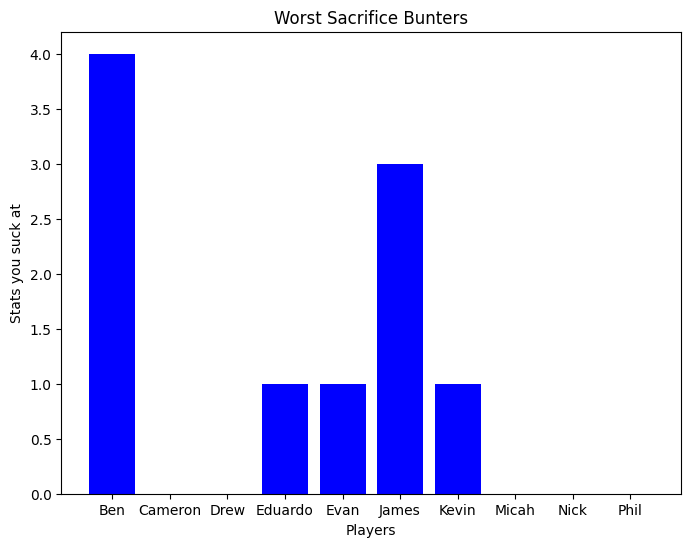

In [1]:
import matplotlib.pyplot as plt

# Data
categories = ['Ben', 'Cameron', 'Drew', 'Eduardo', 'Evan', 'James', 'Kevin', 'Micah', 'Nick', 'Phil']
values = [4, 0, 0, 1, 1, 3, 1, 0, 0, 0]

# Create bar graph
plt.figure(figsize=(8, 6))
plt.bar(categories, values, color='blue')

# Add title and labels
plt.title('Worst Sacrifice Bunters')
plt.xlabel('Players')
plt.ylabel('Stats you suck at')

# Show the graph
plt.show()